### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [20]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/IntProject')

In [21]:

import sys
#
# del sys.modules['data_func']
del sys.modules['utils']
del sys.modules['model_v2']


In [22]:
 # pip install yeoda

In [23]:
# pip install tifftools

In [24]:
# pip install fiona

In [25]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from model_v2 import *
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
import pandas as pd
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

/Users/nadia/PycharmProjects/InterdisciplinaryProject/utils.py:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [26]:
# pip install tqdm

In [27]:
# pip install torchvision



### Data Preparation & Augmentation

In [28]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

In [29]:

train_transform = A.Compose([
    A.Resize(256,256 ),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.RandomResizedCrop(256,256, scale=(0.8, 1.0),p=0.5),
    A.HorizontalFlip(p=0.8),
    A.VerticalFlip(p=0.8),
     A.Blur(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.8),

], )

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),], )


In [30]:
run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask', './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                             './drive/MyDrive/IntProject/test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './drive/MyDrive/IntProject/model_results4.txt'
    model_file = './drive/MyDrive/IntProject/model4.pt'
else:
    train_set = ImageDataset('./train', './train_mask', './train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./val', './val_mask', './val_mask_lacken', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./test', './test_mask', './test_mask_lacken', test_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = 'model_results4_.txt'
    model_file = 'model4_.pt'


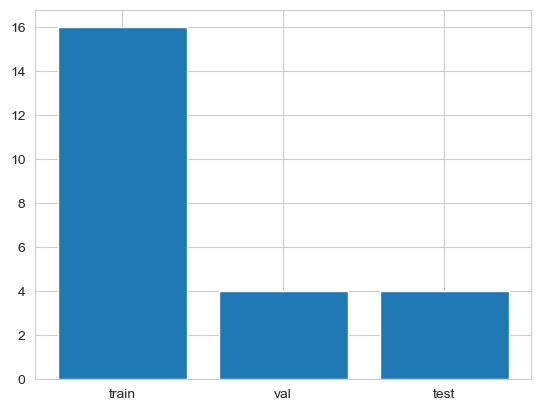

In [31]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

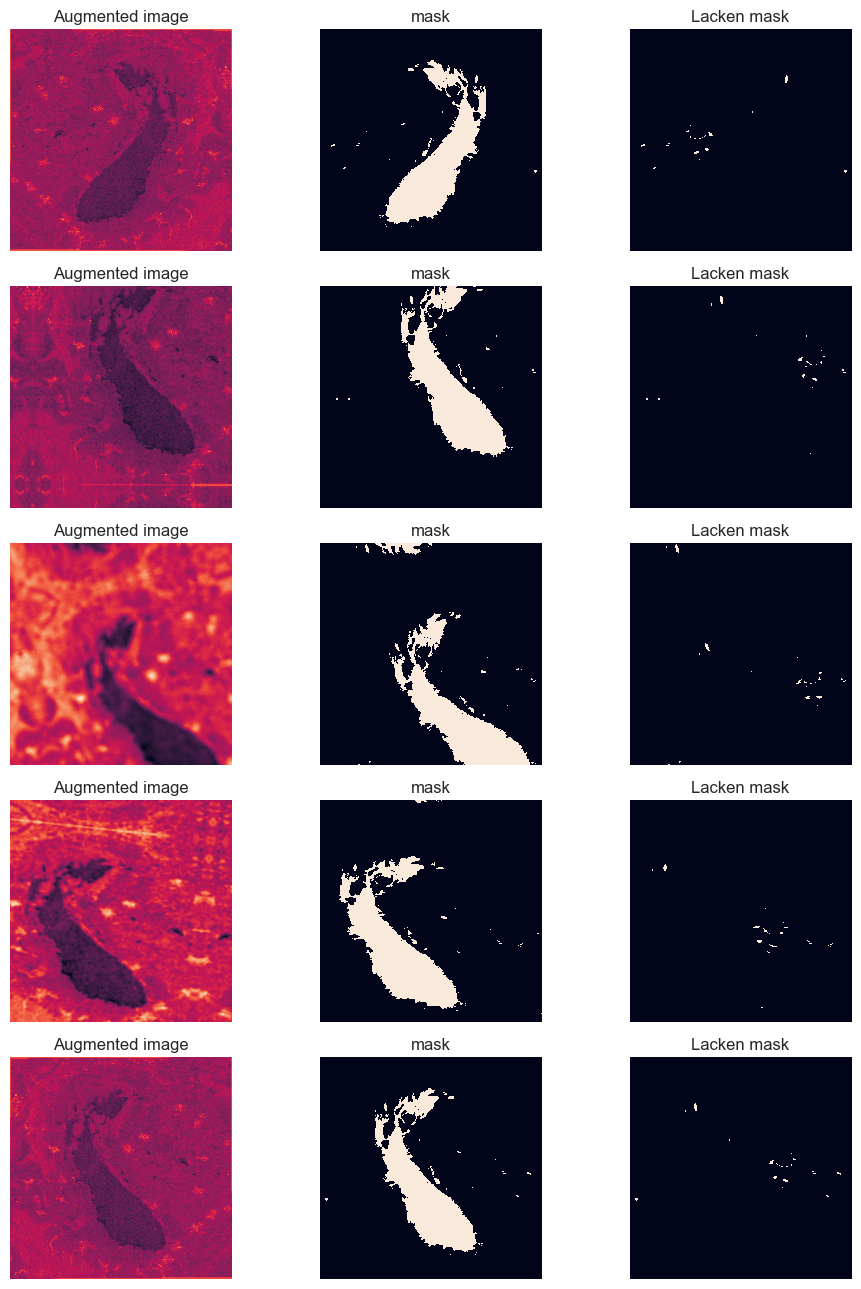

In [32]:
visualize_augmentations(train_set, idx=2, samples=5)


#### Train & Evaluate

In [37]:
epochs = 150
model = UNetFT(1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.8], device=device))


In [38]:
train_evaluate(model, epochs, valloader, valloader, optimizer, criterion, dict_file,
               model_file, best_dice=0)

  1%|          | 1/150 [00:21<52:59, 21.34s/it]

 
 Epoch: 1 
TRAIN FULL: Train Loss: 1.4198 | Train DICE Coeff: 0.2487  | Train IoU Coeff: 0.1428| | Train Bal Accuracy: 54.96 | Train Accuracy: 63.72 
TRAIN LACKENS: Train DICE Coeff: 0.0047  | Train IoU Coeff: 0.0024 | Train Bal Accuracy: 50.46 |  Train Accuracy: 65.71 
VAL FULL: Val Loss: 1.4531 | Val DICE Coeff: 0.2601 | Val IoU Coeff: 0.1461 | Val Bal Accuracy: 51.54 | Val Accuracy: 60.42 
VAL LACKENS: Val DICE Coeff: 0.0057 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 55.18 |  Val Accuracy: 60.98| 


  1%|▏         | 2/150 [00:41<50:31, 20.48s/it]

 
 Epoch: 2 
TRAIN FULL: Train Loss: 1.3444 | Train DICE Coeff: 0.3178  | Train IoU Coeff: 0.2079| | Train Bal Accuracy: 61.97 | Train Accuracy: 80.64 
TRAIN LACKENS: Train DICE Coeff: 0.0053  | Train IoU Coeff: 0.0025 | Train Bal Accuracy: 50.35 |  Train Accuracy: 84.45 
VAL FULL: Val Loss: 1.4539 | Val DICE Coeff: 0.2220 | Val IoU Coeff: 0.1250 | Val Bal Accuracy: 49.55 | Val Accuracy: 51.06 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 50.38 |  Val Accuracy: 51.21| 


  2%|▏         | 3/150 [01:01<49:40, 20.28s/it]

 
 Epoch: 3 
TRAIN FULL: Train Loss: 1.3011 | Train DICE Coeff: 0.4184  | Train IoU Coeff: 0.2623| | Train Bal Accuracy: 69.46 | Train Accuracy: 75.93 
TRAIN LACKENS: Train DICE Coeff: 0.0053  | Train IoU Coeff: 0.0029 | Train Bal Accuracy: 53.00 |  Train Accuracy: 72.90 
VAL FULL: Val Loss: 1.4584 | Val DICE Coeff: 0.1807 | Val IoU Coeff: 0.0995 | Val Bal Accuracy: 49.41 | Val Accuracy: 68.26 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 50.11 |  Val Accuracy: 75.26| 


  3%|▎         | 4/150 [01:21<48:56, 20.11s/it]

 
 Epoch: 4 
TRAIN FULL: Train Loss: 1.2566 | Train DICE Coeff: 0.4175  | Train IoU Coeff: 0.2606| | Train Bal Accuracy: 70.13 | Train Accuracy: 74.05 
TRAIN LACKENS: Train DICE Coeff: 0.0039  | Train IoU Coeff: 0.0032 | Train Bal Accuracy: 53.88 |  Train Accuracy: 69.85 
VAL FULL: Val Loss: 1.4617 | Val DICE Coeff: 0.2402 | Val IoU Coeff: 0.1399 | Val Bal Accuracy: 52.70 | Val Accuracy: 66.09 
VAL LACKENS: Val DICE Coeff: 0.0057 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 54.78 |  Val Accuracy: 69.13| 


  3%|▎         | 5/150 [01:41<48:36, 20.12s/it]

 
 Epoch: 5 
TRAIN FULL: Train Loss: 1.2437 | Train DICE Coeff: 0.4046  | Train IoU Coeff: 0.2547| | Train Bal Accuracy: 69.34 | Train Accuracy: 74.02 
TRAIN LACKENS: Train DICE Coeff: 0.0039  | Train IoU Coeff: 0.0032 | Train Bal Accuracy: 54.47 |  Train Accuracy: 70.34 
VAL FULL: Val Loss: 1.4587 | Val DICE Coeff: 0.2259 | Val IoU Coeff: 0.1275 | Val Bal Accuracy: 50.25 | Val Accuracy: 52.38 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 51.04 |  Val Accuracy: 52.60| 


  4%|▍         | 6/150 [02:01<48:35, 20.25s/it]

 
 Epoch: 6 
TRAIN FULL: Train Loss: 1.2129 | Train DICE Coeff: 0.4280  | Train IoU Coeff: 0.2764| | Train Bal Accuracy: 71.00 | Train Accuracy: 76.64 
TRAIN LACKENS: Train DICE Coeff: 0.0032  | Train IoU Coeff: 0.0028 | Train Bal Accuracy: 52.15 |  Train Accuracy: 72.83 
VAL FULL: Val Loss: 1.4535 | Val DICE Coeff: 0.2483 | Val IoU Coeff: 0.1442 | Val Bal Accuracy: 51.51 | Val Accuracy: 67.71 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 55.49 |  Val Accuracy: 70.90| 


  5%|▍         | 7/150 [02:24<49:58, 20.97s/it]

 
 Epoch: 7 
TRAIN FULL: Train Loss: 1.1965 | Train DICE Coeff: 0.4313  | Train IoU Coeff: 0.2818| | Train Bal Accuracy: 71.80 | Train Accuracy: 76.47 
TRAIN LACKENS: Train DICE Coeff: 0.0049  | Train IoU Coeff: 0.0041 | Train Bal Accuracy: 60.29 |  Train Accuracy: 72.14 
VAL FULL: Val Loss: 1.4420 | Val DICE Coeff: 0.1834 | Val IoU Coeff: 0.1011 | Val Bal Accuracy: 50.59 | Val Accuracy: 68.93 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 50.45 |  Val Accuracy: 75.98| 


  5%|▌         | 8/150 [02:44<49:09, 20.77s/it]

 
 Epoch: 8 
TRAIN FULL: Train Loss: 1.1477 | Train DICE Coeff: 0.4676  | Train IoU Coeff: 0.3508| | Train Bal Accuracy: 77.01 | Train Accuracy: 81.45 
TRAIN LACKENS: Train DICE Coeff: 0.0045  | Train IoU Coeff: 0.0034 | Train Bal Accuracy: 54.90 |  Train Accuracy: 75.48 
VAL FULL: Val Loss: 1.4190 | Val DICE Coeff: 0.2076 | Val IoU Coeff: 0.1145 | Val Bal Accuracy: 52.31 | Val Accuracy: 74.21 
VAL LACKENS: Val DICE Coeff: 0.0071 | Val IoU Coeff: 0.0032 | Val Bal Accuracy: 53.07 |  Val Accuracy: 81.55| 


  6%|▌         | 9/150 [03:04<48:21, 20.58s/it]

 
 Epoch: 9 
TRAIN FULL: Train Loss: 1.1222 | Train DICE Coeff: 0.5461  | Train IoU Coeff: 0.3671| | Train Bal Accuracy: 76.92 | Train Accuracy: 83.45 
TRAIN LACKENS: Train DICE Coeff: 0.0042  | Train IoU Coeff: 0.0045 | Train Bal Accuracy: 59.18 |  Train Accuracy: 78.35 
VAL FULL: Val Loss: 1.3900 | Val DICE Coeff: 0.0983 | Val IoU Coeff: 0.0584 | Val Bal Accuracy: 49.58 | Val Accuracy: 86.68 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 52.92 |  Val Accuracy: 98.93| 


  7%|▋         | 10/150 [03:24<47:36, 20.41s/it]

 
 Epoch: 10 
TRAIN FULL: Train Loss: 1.0608 | Train DICE Coeff: 0.6480  | Train IoU Coeff: 0.4911| | Train Bal Accuracy: 81.41 | Train Accuracy: 89.79 
TRAIN LACKENS: Train DICE Coeff: 0.0032  | Train IoU Coeff: 0.0029 | Train Bal Accuracy: 51.50 |  Train Accuracy: 84.06 
VAL FULL: Val Loss: 1.3605 | Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 50.00 | Val Accuracy: 85.86 
VAL LACKENS: Val DICE Coeff: 0.0085 | Val IoU Coeff: 0.0016 | Val Bal Accuracy: 50.00 |  Val Accuracy: 99.75| 


  7%|▋         | 11/150 [03:44<46:51, 20.23s/it]

 
 Epoch: 11 
TRAIN FULL: Train Loss: 1.0143 | Train DICE Coeff: 0.7796  | Train IoU Coeff: 0.6537| | Train Bal Accuracy: 86.53 | Train Accuracy: 94.33 
TRAIN LACKENS: Train DICE Coeff: 0.0023  | Train IoU Coeff: 0.0016 | Train Bal Accuracy: 47.95 |  Train Accuracy: 86.89 
VAL FULL: Val Loss: 1.3404 | Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 50.00 | Val Accuracy: 85.86 
VAL LACKENS: Val DICE Coeff: 0.0089 | Val IoU Coeff: 0.0016 | Val Bal Accuracy: 50.00 |  Val Accuracy: 99.77| 


  8%|▊         | 12/150 [04:05<47:19, 20.58s/it]

 
 Epoch: 12 
TRAIN FULL: Train Loss: 0.9850 | Train DICE Coeff: 0.8060  | Train IoU Coeff: 0.6810| | Train Bal Accuracy: 88.13 | Train Accuracy: 94.78 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 46.23 |  Train Accuracy: 86.39 
VAL FULL: Val Loss: 1.3895 | Val DICE Coeff: 0.1341 | Val IoU Coeff: 0.1155 | Val Bal Accuracy: 59.44 | Val Accuracy: 70.24 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0044 | Val Bal Accuracy: 52.39 |  Val Accuracy: 76.56| 


  9%|▊         | 13/150 [04:26<47:01, 20.60s/it]

 
 Epoch: 13 
TRAIN FULL: Train Loss: 1.0136 | Train DICE Coeff: 0.7137  | Train IoU Coeff: 0.6005| | Train Bal Accuracy: 84.23 | Train Accuracy: 93.26 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.78 |  Train Accuracy: 86.91 
VAL FULL: Val Loss: 1.7193 | Val DICE Coeff: 0.2549 | Val IoU Coeff: 0.1467 | Val Bal Accuracy: 53.12 | Val Accuracy: 31.46 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 53.07 |  Val Accuracy: 22.23| 


  9%|▉         | 14/150 [04:46<46:28, 20.51s/it]

 
 Epoch: 14 
TRAIN FULL: Train Loss: 0.9310 | Train DICE Coeff: 0.8461  | Train IoU Coeff: 0.7419| | Train Bal Accuracy: 89.09 | Train Accuracy: 96.09 
TRAIN LACKENS: Train DICE Coeff: 0.0003  | Train IoU Coeff: 0.0001 | Train Bal Accuracy: 44.11 |  Train Accuracy: 87.54 
VAL FULL: Val Loss: 2.4550 | Val DICE Coeff: 0.2516 | Val IoU Coeff: 0.1444 | Val Bal Accuracy: 52.33 | Val Accuracy: 21.16 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 51.64 |  Val Accuracy: 8.91| 


 10%|█         | 15/150 [05:07<46:10, 20.53s/it]

 
 Epoch: 15 
TRAIN FULL: Train Loss: 0.9011 | Train DICE Coeff: 0.8521  | Train IoU Coeff: 0.7490| | Train Bal Accuracy: 90.10 | Train Accuracy: 96.12 
TRAIN LACKENS: Train DICE Coeff: 0.0005  | Train IoU Coeff: 0.0002 | Train Bal Accuracy: 44.09 |  Train Accuracy: 86.90 
VAL FULL: Val Loss: 3.4560 | Val DICE Coeff: 0.2535 | Val IoU Coeff: 0.1454 | Val Bal Accuracy: 52.14 | Val Accuracy: 18.13 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 51.65 |  Val Accuracy: 4.67| 


 11%|█         | 16/150 [05:28<46:27, 20.80s/it]

 
 Epoch: 16 
TRAIN FULL: Train Loss: 0.8988 | Train DICE Coeff: 0.8166  | Train IoU Coeff: 0.7071| | Train Bal Accuracy: 89.41 | Train Accuracy: 95.23 
TRAIN LACKENS: Train DICE Coeff: 0.0011  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.66 |  Train Accuracy: 86.15 
VAL FULL: Val Loss: 3.9935 | Val DICE Coeff: 0.2517 | Val IoU Coeff: 0.1442 | Val Bal Accuracy: 51.70 | Val Accuracy: 17.86 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 51.23 |  Val Accuracy: 4.57| 


 11%|█▏        | 17/150 [05:48<45:38, 20.59s/it]

 
 Epoch: 17 
TRAIN FULL: Train Loss: 0.8601 | Train DICE Coeff: 0.8501  | Train IoU Coeff: 0.7416| | Train Bal Accuracy: 91.02 | Train Accuracy: 95.84 
TRAIN LACKENS: Train DICE Coeff: 0.0016  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.78 |  Train Accuracy: 85.90 
VAL FULL: Val Loss: 5.2764 | Val DICE Coeff: 0.2524 | Val IoU Coeff: 0.1447 | Val Bal Accuracy: 51.79 | Val Accuracy: 17.48 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 51.36 |  Val Accuracy: 3.96| 


 12%|█▏        | 18/150 [06:09<45:14, 20.57s/it]

 
 Epoch: 18 
TRAIN FULL: Train Loss: 0.8581 | Train DICE Coeff: 0.8498  | Train IoU Coeff: 0.7462| | Train Bal Accuracy: 90.34 | Train Accuracy: 96.03 
TRAIN LACKENS: Train DICE Coeff: 0.0015  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.90 |  Train Accuracy: 86.63 
VAL FULL: Val Loss: 5.0974 | Val DICE Coeff: 0.2552 | Val IoU Coeff: 0.1465 | Val Bal Accuracy: 52.59 | Val Accuracy: 18.99 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 52.16 |  Val Accuracy: 5.57| 


 13%|█▎        | 19/150 [06:29<44:46, 20.51s/it]

 
 Epoch: 19 
TRAIN FULL: Train Loss: 0.8448 | Train DICE Coeff: 0.8543  | Train IoU Coeff: 0.7486| | Train Bal Accuracy: 90.79 | Train Accuracy: 96.03 
TRAIN LACKENS: Train DICE Coeff: 0.0023  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 45.90 |  Train Accuracy: 86.34 
VAL FULL: Val Loss: 4.5234 | Val DICE Coeff: 0.2590 | Val IoU Coeff: 0.1491 | Val Bal Accuracy: 53.36 | Val Accuracy: 20.99 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 53.09 |  Val Accuracy: 7.70| 


 13%|█▎        | 20/150 [06:50<44:26, 20.51s/it]

 
 Epoch: 20 
TRAIN FULL: Train Loss: 0.8492 | Train DICE Coeff: 0.8325  | Train IoU Coeff: 0.7223| | Train Bal Accuracy: 88.94 | Train Accuracy: 95.67 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.93 |  Train Accuracy: 87.08 
VAL FULL: Val Loss: 4.7674 | Val DICE Coeff: 0.2534 | Val IoU Coeff: 0.1454 | Val Bal Accuracy: 53.15 | Val Accuracy: 19.74 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 51.81 |  Val Accuracy: 6.83| 


 14%|█▍        | 21/150 [07:12<45:19, 21.08s/it]

 
 Epoch: 21 
TRAIN FULL: Train Loss: 0.8270 | Train DICE Coeff: 0.8550  | Train IoU Coeff: 0.7484| | Train Bal Accuracy: 89.86 | Train Accuracy: 96.15 
TRAIN LACKENS: Train DICE Coeff: 0.0002  | Train IoU Coeff: 0.0001 | Train Bal Accuracy: 43.74 |  Train Accuracy: 87.10 
VAL FULL: Val Loss: 5.0081 | Val DICE Coeff: 0.2538 | Val IoU Coeff: 0.1458 | Val Bal Accuracy: 52.64 | Val Accuracy: 20.21 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 51.95 |  Val Accuracy: 7.36| 


 15%|█▍        | 22/150 [07:35<45:44, 21.44s/it]

 
 Epoch: 22 
TRAIN FULL: Train Loss: 0.8153 | Train DICE Coeff: 0.8503  | Train IoU Coeff: 0.7399| | Train Bal Accuracy: 90.58 | Train Accuracy: 95.86 
TRAIN LACKENS: Train DICE Coeff: 0.0005  | Train IoU Coeff: 0.0002 | Train Bal Accuracy: 43.87 |  Train Accuracy: 86.24 
VAL FULL: Val Loss: 4.7204 | Val DICE Coeff: 0.2554 | Val IoU Coeff: 0.1469 | Val Bal Accuracy: 52.91 | Val Accuracy: 21.25 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 52.45 |  Val Accuracy: 8.48| 


 15%|█▌        | 23/150 [07:55<44:54, 21.22s/it]

 
 Epoch: 23 
TRAIN FULL: Train Loss: 0.7919 | Train DICE Coeff: 0.8654  | Train IoU Coeff: 0.7594| | Train Bal Accuracy: 92.83 | Train Accuracy: 96.04 
TRAIN LACKENS: Train DICE Coeff: 0.0022  | Train IoU Coeff: 0.0012 | Train Bal Accuracy: 46.17 |  Train Accuracy: 84.97 
VAL FULL: Val Loss: 4.2216 | Val DICE Coeff: 0.2530 | Val IoU Coeff: 0.1458 | Val Bal Accuracy: 52.71 | Val Accuracy: 22.30 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 52.17 |  Val Accuracy: 10.14| 


 16%|█▌        | 24/150 [08:16<44:29, 21.19s/it]

 
 Epoch: 24 
TRAIN FULL: Train Loss: 0.7874 | Train DICE Coeff: 0.8732  | Train IoU Coeff: 0.7736| | Train Bal Accuracy: 92.64 | Train Accuracy: 96.38 
TRAIN LACKENS: Train DICE Coeff: 0.0003  | Train IoU Coeff: 0.0001 | Train Bal Accuracy: 43.20 |  Train Accuracy: 85.56 
VAL FULL: Val Loss: 3.4527 | Val DICE Coeff: 0.2971 | Val IoU Coeff: 0.1640 | Val Bal Accuracy: 47.20 | Val Accuracy: 35.49 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 58.02 |  Val Accuracy: 24.43| 


 17%|█▋        | 25/150 [08:37<43:49, 21.04s/it]

 
 Epoch: 25 
TRAIN FULL: Train Loss: 0.7774 | Train DICE Coeff: 0.8669  | Train IoU Coeff: 0.7620| | Train Bal Accuracy: 93.19 | Train Accuracy: 96.06 
TRAIN LACKENS: Train DICE Coeff: 0.0007  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.57 |  Train Accuracy: 84.75 
VAL FULL: Val Loss: 4.4882 | Val DICE Coeff: 0.3075 | Val IoU Coeff: 0.1628 | Val Bal Accuracy: 42.87 | Val Accuracy: 36.95 
VAL LACKENS: Val DICE Coeff: 0.0041 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 57.74 |  Val Accuracy: 26.61| 


 17%|█▋        | 26/150 [08:58<43:12, 20.91s/it]

 
 Epoch: 26 
TRAIN FULL: Train Loss: 0.7551 | Train DICE Coeff: 0.8890  | Train IoU Coeff: 0.8009| | Train Bal Accuracy: 94.06 | Train Accuracy: 96.83 
TRAIN LACKENS: Train DICE Coeff: 0.0003  | Train IoU Coeff: 0.0002 | Train Bal Accuracy: 43.12 |  Train Accuracy: 85.22 
VAL FULL: Val Loss: 4.8341 | Val DICE Coeff: 0.2882 | Val IoU Coeff: 0.1635 | Val Bal Accuracy: 50.71 | Val Accuracy: 42.80 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 57.93 |  Val Accuracy: 34.67| 


 18%|█▊        | 27/150 [09:18<42:41, 20.82s/it]

 
 Epoch: 27 
TRAIN FULL: Train Loss: 0.7420 | Train DICE Coeff: 0.8959  | Train IoU Coeff: 0.8119| | Train Bal Accuracy: 94.67 | Train Accuracy: 97.00 
TRAIN LACKENS: Train DICE Coeff: 0.0004  | Train IoU Coeff: 0.0002 | Train Bal Accuracy: 43.20 |  Train Accuracy: 85.06 
VAL FULL: Val Loss: 7.2073 | Val DICE Coeff: 0.2746 | Val IoU Coeff: 0.1573 | Val Bal Accuracy: 61.16 | Val Accuracy: 42.26 
VAL LACKENS: Val DICE Coeff: 0.0059 | Val IoU Coeff: 0.0033 | Val Bal Accuracy: 56.46 |  Val Accuracy: 35.02| 


 19%|█▊        | 28/150 [09:40<43:03, 21.17s/it]

 
 Epoch: 28 
TRAIN FULL: Train Loss: 0.8111 | Train DICE Coeff: 0.7891  | Train IoU Coeff: 0.6667| | Train Bal Accuracy: 90.16 | Train Accuracy: 94.01 
TRAIN LACKENS: Train DICE Coeff: 0.0012  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.42 |  Train Accuracy: 83.96 
VAL FULL: Val Loss: 6.5185 | Val DICE Coeff: 0.2611 | Val IoU Coeff: 0.1509 | Val Bal Accuracy: 55.60 | Val Accuracy: 35.02 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0028 | Val Bal Accuracy: 54.45 |  Val Accuracy: 26.25| 


 19%|█▉        | 29/150 [10:02<42:48, 21.23s/it]

 
 Epoch: 29 
TRAIN FULL: Train Loss: 0.7559 | Train DICE Coeff: 0.8653  | Train IoU Coeff: 0.7686| | Train Bal Accuracy: 93.08 | Train Accuracy: 96.22 
TRAIN LACKENS: Train DICE Coeff: 0.0014  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.33 |  Train Accuracy: 85.02 
VAL FULL: Val Loss: 7.0631 | Val DICE Coeff: 0.2820 | Val IoU Coeff: 0.1610 | Val Bal Accuracy: 55.55 | Val Accuracy: 36.58 
VAL LACKENS: Val DICE Coeff: 0.0060 | Val IoU Coeff: 0.0029 | Val Bal Accuracy: 57.23 |  Val Accuracy: 26.55| 


 20%|██        | 30/150 [10:23<42:26, 21.22s/it]

 
 Epoch: 30 
TRAIN FULL: Train Loss: 0.7391 | Train DICE Coeff: 0.8798  | Train IoU Coeff: 0.7847| | Train Bal Accuracy: 94.08 | Train Accuracy: 96.48 
TRAIN LACKENS: Train DICE Coeff: 0.0012  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.32 |  Train Accuracy: 84.71 
VAL FULL: Val Loss: 10.2464 | Val DICE Coeff: 0.2644 | Val IoU Coeff: 0.1513 | Val Bal Accuracy: 43.94 | Val Accuracy: 23.33 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 53.95 |  Val Accuracy: 10.28| 


 21%|██        | 31/150 [10:44<41:50, 21.09s/it]

 
 Epoch: 31 
TRAIN FULL: Train Loss: 0.7372 | Train DICE Coeff: 0.8733  | Train IoU Coeff: 0.7761| | Train Bal Accuracy: 93.94 | Train Accuracy: 96.30 
TRAIN LACKENS: Train DICE Coeff: 0.0015  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.68 |  Train Accuracy: 84.59 
VAL FULL: Val Loss: 10.3019 | Val DICE Coeff: 0.2759 | Val IoU Coeff: 0.1590 | Val Bal Accuracy: 48.81 | Val Accuracy: 26.01 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 56.41 |  Val Accuracy: 12.36| 


 21%|██▏       | 32/150 [11:04<41:19, 21.01s/it]

 
 Epoch: 32 
TRAIN FULL: Train Loss: 0.7117 | Train DICE Coeff: 0.8902  | Train IoU Coeff: 0.8033| | Train Bal Accuracy: 94.91 | Train Accuracy: 96.80 
TRAIN LACKENS: Train DICE Coeff: 0.0018  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 44.96 |  Train Accuracy: 84.61 
VAL FULL: Val Loss: 9.5287 | Val DICE Coeff: 0.2783 | Val IoU Coeff: 0.1603 | Val Bal Accuracy: 53.37 | Val Accuracy: 26.50 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 56.89 |  Val Accuracy: 12.80| 


 22%|██▏       | 33/150 [11:25<40:44, 20.89s/it]

 
 Epoch: 33 
TRAIN FULL: Train Loss: 0.7096 | Train DICE Coeff: 0.8919  | Train IoU Coeff: 0.8067| | Train Bal Accuracy: 94.77 | Train Accuracy: 96.89 
TRAIN LACKENS: Train DICE Coeff: 0.0009  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.55 |  Train Accuracy: 84.81 
VAL FULL: Val Loss: 7.6813 | Val DICE Coeff: 0.2553 | Val IoU Coeff: 0.1466 | Val Bal Accuracy: 51.59 | Val Accuracy: 18.06 
VAL LACKENS: Val DICE Coeff: 0.0053 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 52.03 |  Val Accuracy: 4.31| 


 23%|██▎       | 34/150 [11:45<40:00, 20.70s/it]

 
 Epoch: 34 
TRAIN FULL: Train Loss: 0.7015 | Train DICE Coeff: 0.8988  | Train IoU Coeff: 0.8162| | Train Bal Accuracy: 94.52 | Train Accuracy: 97.10 
TRAIN LACKENS: Train DICE Coeff: 0.0001  | Train IoU Coeff: 0.0000 | Train Bal Accuracy: 42.74 |  Train Accuracy: 85.28 
VAL FULL: Val Loss: 8.5114 | Val DICE Coeff: 0.2722 | Val IoU Coeff: 0.1558 | Val Bal Accuracy: 54.31 | Val Accuracy: 23.82 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 55.36 |  Val Accuracy: 10.09| 


 23%|██▎       | 35/150 [12:06<39:35, 20.66s/it]

 
 Epoch: 35 
TRAIN FULL: Train Loss: 0.6988 | Train DICE Coeff: 0.8855  | Train IoU Coeff: 0.7918| | Train Bal Accuracy: 94.73 | Train Accuracy: 96.57 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.58 |  Train Accuracy: 84.39 
VAL FULL: Val Loss: 7.7312 | Val DICE Coeff: 0.2549 | Val IoU Coeff: 0.1463 | Val Bal Accuracy: 51.49 | Val Accuracy: 17.86 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 51.91 |  Val Accuracy: 4.12| 


 24%|██▍       | 36/150 [12:27<39:14, 20.66s/it]

 
 Epoch: 36 
TRAIN FULL: Train Loss: 0.6922 | Train DICE Coeff: 0.8949  | Train IoU Coeff: 0.8128| | Train Bal Accuracy: 94.42 | Train Accuracy: 97.05 
TRAIN LACKENS: Train DICE Coeff: 0.0003  | Train IoU Coeff: 0.0001 | Train Bal Accuracy: 43.06 |  Train Accuracy: 85.29 
VAL FULL: Val Loss: 7.4441 | Val DICE Coeff: 0.2673 | Val IoU Coeff: 0.1533 | Val Bal Accuracy: 52.25 | Val Accuracy: 22.33 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 54.53 |  Val Accuracy: 8.59| 


 25%|██▍       | 37/150 [12:47<38:57, 20.68s/it]

 
 Epoch: 37 
TRAIN FULL: Train Loss: 0.6989 | Train DICE Coeff: 0.8858  | Train IoU Coeff: 0.7926| | Train Bal Accuracy: 93.03 | Train Accuracy: 96.75 
TRAIN LACKENS: Train DICE Coeff: 0.0003  | Train IoU Coeff: 0.0001 | Train Bal Accuracy: 43.23 |  Train Accuracy: 85.80 
VAL FULL: Val Loss: 7.1172 | Val DICE Coeff: 0.2809 | Val IoU Coeff: 0.1598 | Val Bal Accuracy: 52.15 | Val Accuracy: 26.17 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 56.70 |  Val Accuracy: 12.43| 


 25%|██▌       | 38/150 [13:09<39:15, 21.03s/it]

 
 Epoch: 38 
TRAIN FULL: Train Loss: 0.6783 | Train DICE Coeff: 0.8985  | Train IoU Coeff: 0.8165| | Train Bal Accuracy: 94.42 | Train Accuracy: 97.12 
TRAIN LACKENS: Train DICE Coeff: 0.0013  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.59 |  Train Accuracy: 85.38 
VAL FULL: Val Loss: 6.1384 | Val DICE Coeff: 0.3382 | Val IoU Coeff: 0.1744 | Val Bal Accuracy: 57.14 | Val Accuracy: 34.93 
VAL LACKENS: Val DICE Coeff: 0.0060 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 60.91 |  Val Accuracy: 21.81| 


 26%|██▌       | 39/150 [13:30<38:43, 20.94s/it]

 
 Epoch: 39 
TRAIN FULL: Train Loss: 0.6944 | Train DICE Coeff: 0.8731  | Train IoU Coeff: 0.7727| | Train Bal Accuracy: 92.31 | Train Accuracy: 96.40 
TRAIN LACKENS: Train DICE Coeff: 0.0007  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.94 |  Train Accuracy: 85.82 
VAL FULL: Val Loss: 5.7716 | Val DICE Coeff: 0.3484 | Val IoU Coeff: 0.1798 | Val Bal Accuracy: 43.41 | Val Accuracy: 37.24 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 62.27 |  Val Accuracy: 23.94| 


 27%|██▋       | 40/150 [13:51<38:37, 21.07s/it]

 
 Epoch: 40 
TRAIN FULL: Train Loss: 0.6658 | Train DICE Coeff: 0.9010  | Train IoU Coeff: 0.8202| | Train Bal Accuracy: 94.12 | Train Accuracy: 97.21 
TRAIN LACKENS: Train DICE Coeff: 0.0006  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.73 |  Train Accuracy: 85.71 
VAL FULL: Val Loss: 4.8956 | Val DICE Coeff: 0.3780 | Val IoU Coeff: 0.1855 | Val Bal Accuracy: 54.53 | Val Accuracy: 40.81 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0028 | Val Bal Accuracy: 63.61 |  Val Accuracy: 28.13| 


 27%|██▋       | 41/150 [14:12<38:09, 21.00s/it]

 
 Epoch: 41 
TRAIN FULL: Train Loss: 0.6603 | Train DICE Coeff: 0.9043  | Train IoU Coeff: 0.8257| | Train Bal Accuracy: 94.02 | Train Accuracy: 97.33 
TRAIN LACKENS: Train DICE Coeff: 0.0003  | Train IoU Coeff: 0.0001 | Train Bal Accuracy: 43.32 |  Train Accuracy: 85.94 
VAL FULL: Val Loss: 4.5034 | Val DICE Coeff: 0.3709 | Val IoU Coeff: 0.1881 | Val Bal Accuracy: 57.38 | Val Accuracy: 41.08 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 64.25 |  Val Accuracy: 28.10| 


 28%|██▊       | 42/150 [14:33<37:42, 20.95s/it]

 
 Epoch: 42 
TRAIN FULL: Train Loss: 0.6475 | Train DICE Coeff: 0.9058  | Train IoU Coeff: 0.8291| | Train Bal Accuracy: 95.11 | Train Accuracy: 97.32 
TRAIN LACKENS: Train DICE Coeff: 0.0007  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.59 |  Train Accuracy: 85.21 
VAL FULL: Val Loss: 3.5305 | Val DICE Coeff: 0.4136 | Val IoU Coeff: 0.2077 | Val Bal Accuracy: 47.98 | Val Accuracy: 48.61 
VAL LACKENS: Val DICE Coeff: 0.0056 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 68.05 |  Val Accuracy: 35.87| 


 29%|██▊       | 43/150 [14:54<37:14, 20.88s/it]

 
 Epoch: 43 
TRAIN FULL: Train Loss: 0.6543 | Train DICE Coeff: 0.8931  | Train IoU Coeff: 0.8054| | Train Bal Accuracy: 94.44 | Train Accuracy: 96.89 
TRAIN LACKENS: Train DICE Coeff: 0.0001  | Train IoU Coeff: 0.0001 | Train Bal Accuracy: 42.70 |  Train Accuracy: 85.05 
VAL FULL: Val Loss: 2.9559 | Val DICE Coeff: 0.4167 | Val IoU Coeff: 0.2058 | Val Bal Accuracy: 60.29 | Val Accuracy: 48.24 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0032 | Val Bal Accuracy: 67.65 |  Val Accuracy: 35.75| 


 29%|██▉       | 44/150 [15:15<36:53, 20.89s/it]

 
 Epoch: 44 
TRAIN FULL: Train Loss: 0.6386 | Train DICE Coeff: 0.9036  | Train IoU Coeff: 0.8245| | Train Bal Accuracy: 94.83 | Train Accuracy: 97.25 
TRAIN LACKENS: Train DICE Coeff: 0.0002  | Train IoU Coeff: 0.0001 | Train Bal Accuracy: 42.90 |  Train Accuracy: 85.28 
VAL FULL: Val Loss: 2.5965 | Val DICE Coeff: 0.4553 | Val IoU Coeff: 0.2157 | Val Bal Accuracy: 60.59 | Val Accuracy: 53.21 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0033 | Val Bal Accuracy: 68.95 |  Val Accuracy: 41.77| 


 30%|███       | 45/150 [15:36<36:38, 20.94s/it]

 
 Epoch: 45 
TRAIN FULL: Train Loss: 0.6308 | Train DICE Coeff: 0.9039  | Train IoU Coeff: 0.8245| | Train Bal Accuracy: 95.14 | Train Accuracy: 97.22 
TRAIN LACKENS: Train DICE Coeff: 0.0005  | Train IoU Coeff: 0.0002 | Train Bal Accuracy: 43.14 |  Train Accuracy: 85.01 
VAL FULL: Val Loss: 2.5939 | Val DICE Coeff: 0.5427 | Val IoU Coeff: 0.2331 | Val Bal Accuracy: 49.91 | Val Accuracy: 60.75 
VAL LACKENS: Val DICE Coeff: 0.0028 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 70.64 |  Val Accuracy: 51.02| 


 31%|███       | 46/150 [15:57<36:19, 20.96s/it]

 
 Epoch: 46 
TRAIN FULL: Train Loss: 0.6251 | Train DICE Coeff: 0.9049  | Train IoU Coeff: 0.8269| | Train Bal Accuracy: 95.31 | Train Accuracy: 97.26 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 43.92 |  Train Accuracy: 84.99 
VAL FULL: Val Loss: 2.2419 | Val DICE Coeff: 0.5291 | Val IoU Coeff: 0.2720 | Val Bal Accuracy: 52.54 | Val Accuracy: 66.62 
VAL LACKENS: Val DICE Coeff: 0.0036 | Val IoU Coeff: 0.0028 | Val Bal Accuracy: 75.62 |  Val Accuracy: 55.82| 


 31%|███▏      | 47/150 [16:17<35:50, 20.88s/it]

 
 Epoch: 47 
TRAIN FULL: Train Loss: 0.6155 | Train DICE Coeff: 0.9094  | Train IoU Coeff: 0.8342| | Train Bal Accuracy: 95.52 | Train Accuracy: 97.39 
TRAIN LACKENS: Train DICE Coeff: 0.0008  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.62 |  Train Accuracy: 85.01 
VAL FULL: Val Loss: 1.8571 | Val DICE Coeff: 0.5192 | Val IoU Coeff: 0.2589 | Val Bal Accuracy: 46.50 | Val Accuracy: 64.76 
VAL LACKENS: Val DICE Coeff: 0.0032 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 74.06 |  Val Accuracy: 54.24| 


 32%|███▏      | 48/150 [16:38<35:10, 20.69s/it]

 
 Epoch: 48 
TRAIN FULL: Train Loss: 0.6190 | Train DICE Coeff: 0.9077  | Train IoU Coeff: 0.8301| | Train Bal Accuracy: 94.62 | Train Accuracy: 97.37 
TRAIN LACKENS: Train DICE Coeff: 0.0005  | Train IoU Coeff: 0.0002 | Train Bal Accuracy: 43.51 |  Train Accuracy: 85.60 
VAL FULL: Val Loss: 1.2901 | Val DICE Coeff: 0.5859 | Val IoU Coeff: 0.3533 | Val Bal Accuracy: 62.24 | Val Accuracy: 75.63 
VAL LACKENS: Val DICE Coeff: 0.0079 | Val IoU Coeff: 0.0042 | Val Bal Accuracy: 83.31 |  Val Accuracy: 63.22| 


 33%|███▎      | 49/150 [16:58<34:41, 20.61s/it]

 
 Epoch: 49 
TRAIN FULL: Train Loss: 0.6109 | Train DICE Coeff: 0.9065  | Train IoU Coeff: 0.8278| | Train Bal Accuracy: 94.89 | Train Accuracy: 97.31 
TRAIN LACKENS: Train DICE Coeff: 0.0008  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.90 |  Train Accuracy: 85.33 
VAL FULL: Val Loss: 1.1071 | Val DICE Coeff: 0.6152 | Val IoU Coeff: 0.3774 | Val Bal Accuracy: 47.87 | Val Accuracy: 80.57 
VAL LACKENS: Val DICE Coeff: 0.0029 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 81.69 |  Val Accuracy: 71.04| 


 33%|███▎      | 50/150 [17:19<34:49, 20.89s/it]

 
 Epoch: 50 
TRAIN FULL: Train Loss: 0.6003 | Train DICE Coeff: 0.9084  | Train IoU Coeff: 0.8323| | Train Bal Accuracy: 95.48 | Train Accuracy: 97.35 
TRAIN LACKENS: Train DICE Coeff: 0.0011  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.09 |  Train Accuracy: 84.98 
VAL FULL: Val Loss: 1.1312 | Val DICE Coeff: 0.6363 | Val IoU Coeff: 0.3800 | Val Bal Accuracy: 42.32 | Val Accuracy: 81.04 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 81.50 |  Val Accuracy: 71.76| 


 34%|███▍      | 51/150 [17:40<34:14, 20.75s/it]

 
 Epoch: 51 
TRAIN FULL: Train Loss: 0.5962 | Train DICE Coeff: 0.9049  | Train IoU Coeff: 0.8278| | Train Bal Accuracy: 95.51 | Train Accuracy: 97.26 
TRAIN LACKENS: Train DICE Coeff: 0.0007  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.37 |  Train Accuracy: 84.83 
VAL FULL: Val Loss: 0.8102 | Val DICE Coeff: 0.7037 | Val IoU Coeff: 0.5414 | Val Bal Accuracy: 43.75 | Val Accuracy: 90.41 
VAL LACKENS: Val DICE Coeff: 0.0015 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 86.10 |  Val Accuracy: 81.68| 


 35%|███▍      | 52/150 [18:01<33:53, 20.75s/it]

 
 Epoch: 52 
TRAIN FULL: Train Loss: 0.5917 | Train DICE Coeff: 0.9103  | Train IoU Coeff: 0.8354| | Train Bal Accuracy: 95.14 | Train Accuracy: 97.44 
TRAIN LACKENS: Train DICE Coeff: 0.0008  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.75 |  Train Accuracy: 85.34 
VAL FULL: Val Loss: 0.8425 | Val DICE Coeff: 0.7547 | Val IoU Coeff: 0.5229 | Val Bal Accuracy: 57.71 | Val Accuracy: 89.06 
VAL LACKENS: Val DICE Coeff: 0.0040 | Val IoU Coeff: 0.0043 | Val Bal Accuracy: 87.30 |  Val Accuracy: 79.13| 


 35%|███▌      | 53/150 [18:22<33:38, 20.81s/it]

 
 Epoch: 53 
TRAIN FULL: Train Loss: 0.5823 | Train DICE Coeff: 0.9115  | Train IoU Coeff: 0.8379| | Train Bal Accuracy: 95.48 | Train Accuracy: 97.47 
TRAIN LACKENS: Train DICE Coeff: 0.0007  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.57 |  Train Accuracy: 85.14 
VAL FULL: Val Loss: 0.7937 | Val DICE Coeff: 0.7412 | Val IoU Coeff: 0.5287 | Val Bal Accuracy: 43.72 | Val Accuracy: 89.75 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 86.19 |  Val Accuracy: 80.69| 


 36%|███▌      | 54/150 [18:42<32:59, 20.62s/it]

 
 Epoch: 54 
TRAIN FULL: Train Loss: 0.5796 | Train DICE Coeff: 0.9059  | Train IoU Coeff: 0.8293| | Train Bal Accuracy: 95.53 | Train Accuracy: 97.29 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 43.86 |  Train Accuracy: 84.86 
VAL FULL: Val Loss: 0.5847 | Val DICE Coeff: 0.8739 | Val IoU Coeff: 0.7746 | Val Bal Accuracy: 43.21 | Val Accuracy: 96.49 
VAL LACKENS: Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 91.88 |  Val Accuracy: 86.22| 


 37%|███▋      | 55/150 [19:03<33:05, 20.91s/it]

 
 Epoch: 55 
TRAIN FULL: Train Loss: 0.5697 | Train DICE Coeff: 0.9147  | Train IoU Coeff: 0.8432| | Train Bal Accuracy: 95.58 | Train Accuracy: 97.56 
TRAIN LACKENS: Train DICE Coeff: 0.0008  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.68 |  Train Accuracy: 85.21 
VAL FULL: Val Loss: 0.7306 | Val DICE Coeff: 0.7748 | Val IoU Coeff: 0.5908 | Val Bal Accuracy: 55.04 | Val Accuracy: 91.91 
VAL LACKENS: Val DICE Coeff: 0.0040 | Val IoU Coeff: 0.0040 | Val Bal Accuracy: 88.02 |  Val Accuracy: 82.56| 


 37%|███▋      | 56/150 [19:23<32:21, 20.66s/it]

 
 Epoch: 56 
TRAIN FULL: Train Loss: 0.5656 | Train DICE Coeff: 0.9132  | Train IoU Coeff: 0.8401| | Train Bal Accuracy: 95.79 | Train Accuracy: 97.49 
TRAIN LACKENS: Train DICE Coeff: 0.0017  | Train IoU Coeff: 0.0008 | Train Bal Accuracy: 44.89 |  Train Accuracy: 84.97 
VAL FULL: Val Loss: 0.5635 | Val DICE Coeff: 0.8868 | Val IoU Coeff: 0.7932 | Val Bal Accuracy: 43.21 | Val Accuracy: 96.80 
VAL LACKENS: Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 92.54 |  Val Accuracy: 86.19| 


 38%|███▊      | 57/150 [19:44<32:08, 20.73s/it]

 
 Epoch: 57 
TRAIN FULL: Train Loss: 0.5758 | Train DICE Coeff: 0.9021  | Train IoU Coeff: 0.8223| | Train Bal Accuracy: 94.44 | Train Accuracy: 97.23 
TRAIN LACKENS: Train DICE Coeff: 0.0006  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.65 |  Train Accuracy: 85.54 
VAL FULL: Val Loss: 0.5515 | Val DICE Coeff: 0.8966 | Val IoU Coeff: 0.8141 | Val Bal Accuracy: 43.59 | Val Accuracy: 97.21 
VAL LACKENS: Val DICE Coeff: 0.0002 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 92.74 |  Val Accuracy: 86.66| 


 39%|███▊      | 58/150 [20:06<32:03, 20.90s/it]

 
 Epoch: 58 
TRAIN FULL: Train Loss: 0.5537 | Train DICE Coeff: 0.9186  | Train IoU Coeff: 0.8498| | Train Bal Accuracy: 95.71 | Train Accuracy: 97.68 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.03 |  Train Accuracy: 85.29 
VAL FULL: Val Loss: 0.6392 | Val DICE Coeff: 0.8187 | Val IoU Coeff: 0.6865 | Val Bal Accuracy: 50.60 | Val Accuracy: 94.52 
VAL LACKENS: Val DICE Coeff: 0.0037 | Val IoU Coeff: 0.0028 | Val Bal Accuracy: 90.47 |  Val Accuracy: 84.51| 


 39%|███▉      | 59/150 [20:26<31:23, 20.70s/it]

 
 Epoch: 59 
TRAIN FULL: Train Loss: 0.5543 | Train DICE Coeff: 0.9105  | Train IoU Coeff: 0.8354| | Train Bal Accuracy: 95.68 | Train Accuracy: 97.40 
TRAIN LACKENS: Train DICE Coeff: 0.0008  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.66 |  Train Accuracy: 84.93 
VAL FULL: Val Loss: 0.5728 | Val DICE Coeff: 0.8749 | Val IoU Coeff: 0.7859 | Val Bal Accuracy: 43.48 | Val Accuracy: 96.74 
VAL LACKENS: Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 91.62 |  Val Accuracy: 86.75| 


 40%|████      | 60/150 [20:47<31:22, 20.91s/it]

 
 Epoch: 60 
TRAIN FULL: Train Loss: 0.5619 | Train DICE Coeff: 0.8994  | Train IoU Coeff: 0.8117| | Train Bal Accuracy: 95.38 | Train Accuracy: 96.94 
TRAIN LACKENS: Train DICE Coeff: 0.0016  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.06 |  Train Accuracy: 84.49 
VAL FULL: Val Loss: 0.6259 | Val DICE Coeff: 0.8375 | Val IoU Coeff: 0.6936 | Val Bal Accuracy: 52.89 | Val Accuracy: 94.57 
VAL LACKENS: Val DICE Coeff: 0.0041 | Val IoU Coeff: 0.0034 | Val Bal Accuracy: 91.35 |  Val Accuracy: 84.01| 


 41%|████      | 61/150 [21:09<31:16, 21.08s/it]

 
 Epoch: 61 
TRAIN FULL: Train Loss: 0.5455 | Train DICE Coeff: 0.9161  | Train IoU Coeff: 0.8447| | Train Bal Accuracy: 95.59 | Train Accuracy: 97.58 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.88 |  Train Accuracy: 85.24 
VAL FULL: Val Loss: 0.6014 | Val DICE Coeff: 0.8416 | Val IoU Coeff: 0.7130 | Val Bal Accuracy: 42.75 | Val Accuracy: 95.12 
VAL LACKENS: Val DICE Coeff: 0.0002 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 91.17 |  Val Accuracy: 84.81| 


 41%|████▏     | 62/150 [21:30<31:02, 21.16s/it]

 
 Epoch: 62 
TRAIN FULL: Train Loss: 0.5379 | Train DICE Coeff: 0.9170  | Train IoU Coeff: 0.8469| | Train Bal Accuracy: 95.44 | Train Accuracy: 97.64 
TRAIN LACKENS: Train DICE Coeff: 0.0006  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.51 |  Train Accuracy: 85.40 
VAL FULL: Val Loss: 0.5224 | Val DICE Coeff: 0.9032 | Val IoU Coeff: 0.8228 | Val Bal Accuracy: 43.37 | Val Accuracy: 97.29 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 93.73 |  Val Accuracy: 86.06| 


 42%|████▏     | 63/150 [21:50<30:18, 20.91s/it]

 
 Epoch: 63 
TRAIN FULL: Train Loss: 0.5394 | Train DICE Coeff: 0.9121  | Train IoU Coeff: 0.8383| | Train Bal Accuracy: 95.16 | Train Accuracy: 97.49 
TRAIN LACKENS: Train DICE Coeff: 0.0008  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.94 |  Train Accuracy: 85.41 
VAL FULL: Val Loss: 0.5170 | Val DICE Coeff: 0.9062 | Val IoU Coeff: 0.8281 | Val Bal Accuracy: 43.61 | Val Accuracy: 97.39 
VAL LACKENS: Val DICE Coeff: 0.0005 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 93.87 |  Val Accuracy: 86.10| 


 43%|████▎     | 64/150 [22:11<29:47, 20.79s/it]

 
 Epoch: 64 
TRAIN FULL: Train Loss: 0.5295 | Train DICE Coeff: 0.9178  | Train IoU Coeff: 0.8487| | Train Bal Accuracy: 95.40 | Train Accuracy: 97.68 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 45.75 |  Train Accuracy: 85.52 
VAL FULL: Val Loss: 0.5109 | Val DICE Coeff: 0.9119 | Val IoU Coeff: 0.8378 | Val Bal Accuracy: 43.96 | Val Accuracy: 97.53 
VAL LACKENS: Val DICE Coeff: 0.0008 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 94.44 |  Val Accuracy: 85.93| 


 43%|████▎     | 65/150 [22:31<29:17, 20.68s/it]

 
 Epoch: 65 
TRAIN FULL: Train Loss: 0.5279 | Train DICE Coeff: 0.9164  | Train IoU Coeff: 0.8456| | Train Bal Accuracy: 95.12 | Train Accuracy: 97.63 
TRAIN LACKENS: Train DICE Coeff: 0.0009  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 43.97 |  Train Accuracy: 85.63 
VAL FULL: Val Loss: 0.5299 | Val DICE Coeff: 0.8979 | Val IoU Coeff: 0.8152 | Val Bal Accuracy: 44.34 | Val Accuracy: 97.14 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 93.78 |  Val Accuracy: 85.86| 


 44%|████▍     | 66/150 [22:52<28:45, 20.55s/it]

 
 Epoch: 66 
TRAIN FULL: Train Loss: 0.5166 | Train DICE Coeff: 0.9199  | Train IoU Coeff: 0.8520| | Train Bal Accuracy: 95.85 | Train Accuracy: 97.71 
TRAIN LACKENS: Train DICE Coeff: 0.0020  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.36 |  Train Accuracy: 85.24 
VAL FULL: Val Loss: 0.5076 | Val DICE Coeff: 0.9122 | Val IoU Coeff: 0.8390 | Val Bal Accuracy: 43.77 | Val Accuracy: 97.57 
VAL LACKENS: Val DICE Coeff: 0.0005 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 94.18 |  Val Accuracy: 86.19| 


 45%|████▍     | 67/150 [23:12<28:13, 20.41s/it]

 
 Epoch: 67 
TRAIN FULL: Train Loss: 0.5128 | Train DICE Coeff: 0.9187  | Train IoU Coeff: 0.8508| | Train Bal Accuracy: 95.85 | Train Accuracy: 97.68 
TRAIN LACKENS: Train DICE Coeff: 0.0007  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.59 |  Train Accuracy: 85.21 
VAL FULL: Val Loss: 0.5409 | Val DICE Coeff: 0.8852 | Val IoU Coeff: 0.7925 | Val Bal Accuracy: 43.02 | Val Accuracy: 96.75 
VAL LACKENS: Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 92.97 |  Val Accuracy: 85.83| 


 45%|████▌     | 68/150 [23:32<27:45, 20.31s/it]

 
 Epoch: 68 
TRAIN FULL: Train Loss: 0.5082 | Train DICE Coeff: 0.9178  | Train IoU Coeff: 0.8476| | Train Bal Accuracy: 95.99 | Train Accuracy: 97.62 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.40 |  Train Accuracy: 85.02 
VAL FULL: Val Loss: 0.5379 | Val DICE Coeff: 0.8850 | Val IoU Coeff: 0.7923 | Val Bal Accuracy: 44.34 | Val Accuracy: 96.71 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 93.40 |  Val Accuracy: 85.49| 


 46%|████▌     | 69/150 [23:52<27:26, 20.33s/it]

 
 Epoch: 69 
TRAIN FULL: Train Loss: 0.5049 | Train DICE Coeff: 0.9177  | Train IoU Coeff: 0.8485| | Train Bal Accuracy: 95.83 | Train Accuracy: 97.64 
TRAIN LACKENS: Train DICE Coeff: 0.0017  | Train IoU Coeff: 0.0008 | Train Bal Accuracy: 45.14 |  Train Accuracy: 85.19 
VAL FULL: Val Loss: 0.5359 | Val DICE Coeff: 0.8829 | Val IoU Coeff: 0.7895 | Val Bal Accuracy: 43.07 | Val Accuracy: 96.71 
VAL LACKENS: Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 92.74 |  Val Accuracy: 85.93| 


 47%|████▋     | 70/150 [24:13<27:22, 20.54s/it]

 
 Epoch: 70 
TRAIN FULL: Train Loss: 0.4957 | Train DICE Coeff: 0.9234  | Train IoU Coeff: 0.8578| | Train Bal Accuracy: 96.07 | Train Accuracy: 97.80 
TRAIN LACKENS: Train DICE Coeff: 0.0014  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.50 |  Train Accuracy: 85.22 
VAL FULL: Val Loss: 0.5351 | Val DICE Coeff: 0.8874 | Val IoU Coeff: 0.7965 | Val Bal Accuracy: 43.24 | Val Accuracy: 96.80 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 93.34 |  Val Accuracy: 85.66| 


 47%|████▋     | 71/150 [24:34<27:04, 20.56s/it]

 
 Epoch: 71 
TRAIN FULL: Train Loss: 0.4913 | Train DICE Coeff: 0.9236  | Train IoU Coeff: 0.8590| | Train Bal Accuracy: 95.94 | Train Accuracy: 97.84 
TRAIN LACKENS: Train DICE Coeff: 0.0007  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.72 |  Train Accuracy: 85.36 
VAL FULL: Val Loss: 0.5102 | Val DICE Coeff: 0.9016 | Val IoU Coeff: 0.8224 | Val Bal Accuracy: 43.95 | Val Accuracy: 97.32 
VAL LACKENS: Val DICE Coeff: 0.0006 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 93.30 |  Val Accuracy: 86.43| 


 48%|████▊     | 72/150 [24:55<27:00, 20.77s/it]

 
 Epoch: 72 
TRAIN FULL: Train Loss: 0.5001 | Train DICE Coeff: 0.9126  | Train IoU Coeff: 0.8392| | Train Bal Accuracy: 95.22 | Train Accuracy: 97.50 
TRAIN LACKENS: Train DICE Coeff: 0.0013  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.37 |  Train Accuracy: 85.37 
VAL FULL: Val Loss: 0.5159 | Val DICE Coeff: 0.8899 | Val IoU Coeff: 0.8092 | Val Bal Accuracy: 43.62 | Val Accuracy: 97.15 
VAL LACKENS: Val DICE Coeff: 0.0002 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 92.29 |  Val Accuracy: 86.86| 


 49%|████▊     | 73/150 [25:16<26:37, 20.75s/it]

 
 Epoch: 73 
TRAIN FULL: Train Loss: 0.4877 | Train DICE Coeff: 0.9199  | Train IoU Coeff: 0.8513| | Train Bal Accuracy: 95.47 | Train Accuracy: 97.72 
TRAIN LACKENS: Train DICE Coeff: 0.0007  | Train IoU Coeff: 0.0003 | Train Bal Accuracy: 43.74 |  Train Accuracy: 85.50 
VAL FULL: Val Loss: 0.5246 | Val DICE Coeff: 0.8837 | Val IoU Coeff: 0.7984 | Val Bal Accuracy: 43.54 | Val Accuracy: 96.91 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 92.49 |  Val Accuracy: 86.39| 


 49%|████▉     | 74/150 [25:36<26:10, 20.66s/it]

 
 Epoch: 74 
TRAIN FULL: Train Loss: 0.4898 | Train DICE Coeff: 0.9154  | Train IoU Coeff: 0.8438| | Train Bal Accuracy: 95.30 | Train Accuracy: 97.59 
TRAIN LACKENS: Train DICE Coeff: 0.0015  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.77 |  Train Accuracy: 85.44 
VAL FULL: Val Loss: 0.4966 | Val DICE Coeff: 0.9081 | Val IoU Coeff: 0.8341 | Val Bal Accuracy: 44.11 | Val Accuracy: 97.51 
VAL LACKENS: Val DICE Coeff: 0.0007 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 93.75 |  Val Accuracy: 86.39| 


 50%|█████     | 75/150 [25:57<25:55, 20.74s/it]

 
 Epoch: 75 
TRAIN FULL: Train Loss: 0.4839 | Train DICE Coeff: 0.9164  | Train IoU Coeff: 0.8448| | Train Bal Accuracy: 95.36 | Train Accuracy: 97.60 
TRAIN LACKENS: Train DICE Coeff: 0.0016  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.84 |  Train Accuracy: 85.44 
VAL FULL: Val Loss: 0.4877 | Val DICE Coeff: 0.9132 | Val IoU Coeff: 0.8406 | Val Bal Accuracy: 44.23 | Val Accuracy: 97.61 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 94.03 |  Val Accuracy: 86.31| 


 51%|█████     | 76/150 [26:17<25:26, 20.63s/it]

 
 Epoch: 76 
TRAIN FULL: Train Loss: 0.4714 | Train DICE Coeff: 0.9263  | Train IoU Coeff: 0.8625| | Train Bal Accuracy: 95.61 | Train Accuracy: 97.92 
TRAIN LACKENS: Train DICE Coeff: 0.0016  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.98 |  Train Accuracy: 85.69 
VAL FULL: Val Loss: 0.4987 | Val DICE Coeff: 0.9071 | Val IoU Coeff: 0.8310 | Val Bal Accuracy: 43.35 | Val Accuracy: 97.47 
VAL LACKENS: Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 93.51 |  Val Accuracy: 86.49| 


 51%|█████▏    | 77/150 [26:39<25:17, 20.78s/it]

 
 Epoch: 77 
TRAIN FULL: Train Loss: 0.4699 | Train DICE Coeff: 0.9223  | Train IoU Coeff: 0.8550| | Train Bal Accuracy: 95.71 | Train Accuracy: 97.77 
TRAIN LACKENS: Train DICE Coeff: 0.0014  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.69 |  Train Accuracy: 85.44 
VAL FULL: Val Loss: 0.4937 | Val DICE Coeff: 0.9112 | Val IoU Coeff: 0.8376 | Val Bal Accuracy: 43.47 | Val Accuracy: 97.57 
VAL LACKENS: Val DICE Coeff: 0.0002 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 93.82 |  Val Accuracy: 86.42| 


 52%|█████▏    | 78/150 [26:59<24:56, 20.79s/it]

 
 Epoch: 78 
TRAIN FULL: Train Loss: 0.4675 | Train DICE Coeff: 0.9198  | Train IoU Coeff: 0.8512| | Train Bal Accuracy: 95.89 | Train Accuracy: 97.69 
TRAIN LACKENS: Train DICE Coeff: 0.0023  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 45.81 |  Train Accuracy: 85.21 
VAL FULL: Val Loss: 0.4915 | Val DICE Coeff: 0.9147 | Val IoU Coeff: 0.8441 | Val Bal Accuracy: 43.27 | Val Accuracy: 97.67 
VAL LACKENS: Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 94.14 |  Val Accuracy: 86.33| 


 53%|█████▎    | 79/150 [27:20<24:36, 20.80s/it]

 
 Epoch: 79 
TRAIN FULL: Train Loss: 0.4619 | Train DICE Coeff: 0.9197  | Train IoU Coeff: 0.8519| | Train Bal Accuracy: 96.08 | Train Accuracy: 97.69 
TRAIN LACKENS: Train DICE Coeff: 0.0017  | Train IoU Coeff: 0.0008 | Train Bal Accuracy: 44.89 |  Train Accuracy: 85.06 
VAL FULL: Val Loss: 0.4870 | Val DICE Coeff: 0.9156 | Val IoU Coeff: 0.8454 | Val Bal Accuracy: 43.27 | Val Accuracy: 97.69 
VAL LACKENS: Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 94.18 |  Val Accuracy: 86.33| 


 53%|█████▎    | 80/150 [27:41<24:12, 20.75s/it]

 
 Epoch: 80 
TRAIN FULL: Train Loss: 0.4573 | Train DICE Coeff: 0.9204  | Train IoU Coeff: 0.8527| | Train Bal Accuracy: 96.27 | Train Accuracy: 97.70 
TRAIN LACKENS: Train DICE Coeff: 0.0019  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.25 |  Train Accuracy: 84.97 
VAL FULL: Val Loss: 0.4848 | Val DICE Coeff: 0.9092 | Val IoU Coeff: 0.8374 | Val Bal Accuracy: 43.70 | Val Accuracy: 97.57 
VAL LACKENS: Val DICE Coeff: 0.0004 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 93.80 |  Val Accuracy: 86.41| 


 54%|█████▍    | 81/150 [28:01<23:46, 20.67s/it]

 
 Epoch: 81 
TRAIN FULL: Train Loss: 0.4517 | Train DICE Coeff: 0.9222  | Train IoU Coeff: 0.8549| | Train Bal Accuracy: 96.16 | Train Accuracy: 97.74 
TRAIN LACKENS: Train DICE Coeff: 0.0016  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.81 |  Train Accuracy: 85.08 
VAL FULL: Val Loss: 0.4723 | Val DICE Coeff: 0.9177 | Val IoU Coeff: 0.8491 | Val Bal Accuracy: 43.92 | Val Accuracy: 97.74 
VAL LACKENS: Val DICE Coeff: 0.0007 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 94.43 |  Val Accuracy: 86.23| 


 55%|█████▍    | 82/150 [28:22<23:26, 20.68s/it]

 
 Epoch: 82 
TRAIN FULL: Train Loss: 0.4475 | Train DICE Coeff: 0.9245  | Train IoU Coeff: 0.8590| | Train Bal Accuracy: 96.02 | Train Accuracy: 97.83 
TRAIN LACKENS: Train DICE Coeff: 0.0015  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.79 |  Train Accuracy: 85.31 
VAL FULL: Val Loss: 0.4654 | Val DICE Coeff: 0.9192 | Val IoU Coeff: 0.8515 | Val Bal Accuracy: 43.95 | Val Accuracy: 97.78 
VAL LACKENS: Val DICE Coeff: 0.0007 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 94.43 |  Val Accuracy: 86.29| 


 55%|█████▌    | 83/150 [28:43<23:04, 20.66s/it]

 
 Epoch: 83 
TRAIN FULL: Train Loss: 0.4416 | Train DICE Coeff: 0.9276  | Train IoU Coeff: 0.8646| | Train Bal Accuracy: 96.00 | Train Accuracy: 97.93 
TRAIN LACKENS: Train DICE Coeff: 0.0015  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.85 |  Train Accuracy: 85.46 
VAL FULL: Val Loss: 0.4724 | Val DICE Coeff: 0.9077 | Val IoU Coeff: 0.8313 | Val Bal Accuracy: 43.71 | Val Accuracy: 97.43 
VAL LACKENS: Val DICE Coeff: 0.0005 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 94.19 |  Val Accuracy: 85.98| 


 56%|█████▌    | 84/150 [29:05<23:09, 21.05s/it]

 
 Epoch: 84 
TRAIN FULL: Train Loss: 0.4431 | Train DICE Coeff: 0.9245  | Train IoU Coeff: 0.8591| | Train Bal Accuracy: 95.58 | Train Accuracy: 97.85 
TRAIN LACKENS: Train DICE Coeff: 0.0013  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.62 |  Train Accuracy: 85.62 
VAL FULL: Val Loss: 0.4627 | Val DICE Coeff: 0.9144 | Val IoU Coeff: 0.8448 | Val Bal Accuracy: 44.18 | Val Accuracy: 97.69 
VAL LACKENS: Val DICE Coeff: 0.0007 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 93.93 |  Val Accuracy: 86.53| 


 57%|█████▋    | 85/150 [29:26<22:48, 21.06s/it]

 
 Epoch: 85 
TRAIN FULL: Train Loss: 0.4376 | Train DICE Coeff: 0.9238  | Train IoU Coeff: 0.8584| | Train Bal Accuracy: 95.75 | Train Accuracy: 97.83 
TRAIN LACKENS: Train DICE Coeff: 0.0020  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.47 |  Train Accuracy: 85.48 
VAL FULL: Val Loss: 0.4797 | Val DICE Coeff: 0.8962 | Val IoU Coeff: 0.8202 | Val Bal Accuracy: 43.76 | Val Accuracy: 97.30 
VAL LACKENS: Val DICE Coeff: 0.0004 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 93.04 |  Val Accuracy: 86.55| 


 57%|█████▋    | 86/150 [29:47<22:40, 21.26s/it]

 
 Epoch: 86 
TRAIN FULL: Train Loss: 0.4331 | Train DICE Coeff: 0.9257  | Train IoU Coeff: 0.8623| | Train Bal Accuracy: 95.75 | Train Accuracy: 97.91 
TRAIN LACKENS: Train DICE Coeff: 0.0012  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.45 |  Train Accuracy: 85.59 
VAL FULL: Val Loss: 0.4755 | Val DICE Coeff: 0.9000 | Val IoU Coeff: 0.8262 | Val Bal Accuracy: 44.16 | Val Accuracy: 97.43 
VAL LACKENS: Val DICE Coeff: 0.0006 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 92.88 |  Val Accuracy: 86.86| 


 58%|█████▊    | 87/150 [30:09<22:21, 21.29s/it]

 
 Epoch: 87 
TRAIN FULL: Train Loss: 0.4267 | Train DICE Coeff: 0.9272  | Train IoU Coeff: 0.8650| | Train Bal Accuracy: 95.96 | Train Accuracy: 97.94 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 44.07 |  Train Accuracy: 85.50 
VAL FULL: Val Loss: 0.4503 | Val DICE Coeff: 0.9226 | Val IoU Coeff: 0.8570 | Val Bal Accuracy: 44.36 | Val Accuracy: 97.88 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 94.49 |  Val Accuracy: 86.41| 


 59%|█████▊    | 88/150 [30:30<21:51, 21.16s/it]

 
 Epoch: 88 
TRAIN FULL: Train Loss: 0.4267 | Train DICE Coeff: 0.9276  | Train IoU Coeff: 0.8646| | Train Bal Accuracy: 95.70 | Train Accuracy: 97.95 
TRAIN LACKENS: Train DICE Coeff: 0.0020  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.59 |  Train Accuracy: 85.68 
VAL FULL: Val Loss: 0.4718 | Val DICE Coeff: 0.9095 | Val IoU Coeff: 0.8353 | Val Bal Accuracy: 44.23 | Val Accuracy: 97.57 
VAL LACKENS: Val DICE Coeff: 0.0007 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 93.16 |  Val Accuracy: 86.86| 


 59%|█████▉    | 89/150 [30:50<21:20, 20.99s/it]

 
 Epoch: 89 
TRAIN FULL: Train Loss: 0.4217 | Train DICE Coeff: 0.9255  | Train IoU Coeff: 0.8619| | Train Bal Accuracy: 95.99 | Train Accuracy: 97.88 
TRAIN LACKENS: Train DICE Coeff: 0.0014  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.74 |  Train Accuracy: 85.38 
VAL FULL: Val Loss: 0.4456 | Val DICE Coeff: 0.9239 | Val IoU Coeff: 0.8590 | Val Bal Accuracy: 44.76 | Val Accuracy: 97.91 
VAL LACKENS: Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 94.54 |  Val Accuracy: 86.42| 


 60%|██████    | 90/150 [31:11<20:57, 20.96s/it]

 
 Epoch: 90 
TRAIN FULL: Train Loss: 0.4133 | Train DICE Coeff: 0.9284  | Train IoU Coeff: 0.8667| | Train Bal Accuracy: 96.33 | Train Accuracy: 97.96 
TRAIN LACKENS: Train DICE Coeff: 0.0027  | Train IoU Coeff: 0.0013 | Train Bal Accuracy: 46.66 |  Train Accuracy: 85.30 
VAL FULL: Val Loss: 0.4403 | Val DICE Coeff: 0.9244 | Val IoU Coeff: 0.8595 | Val Bal Accuracy: 44.68 | Val Accuracy: 97.92 
VAL LACKENS: Val DICE Coeff: 0.0013 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 94.66 |  Val Accuracy: 86.33| 


 61%|██████    | 91/150 [31:31<20:24, 20.76s/it]

 
 Epoch: 91 
TRAIN FULL: Train Loss: 0.4146 | Train DICE Coeff: 0.9260  | Train IoU Coeff: 0.8620| | Train Bal Accuracy: 96.14 | Train Accuracy: 97.88 
TRAIN LACKENS: Train DICE Coeff: 0.0030  | Train IoU Coeff: 0.0015 | Train Bal Accuracy: 47.01 |  Train Accuracy: 85.29 
VAL FULL: Val Loss: 0.4396 | Val DICE Coeff: 0.9223 | Val IoU Coeff: 0.8565 | Val Bal Accuracy: 44.35 | Val Accuracy: 97.88 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 94.29 |  Val Accuracy: 86.53| 


 61%|██████▏   | 92/150 [31:52<20:06, 20.80s/it]

 
 Epoch: 92 
TRAIN FULL: Train Loss: 0.4162 | Train DICE Coeff: 0.9218  | Train IoU Coeff: 0.8557| | Train Bal Accuracy: 95.65 | Train Accuracy: 97.79 
TRAIN LACKENS: Train DICE Coeff: 0.0020  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 45.53 |  Train Accuracy: 85.49 
VAL FULL: Val Loss: 0.4446 | Val DICE Coeff: 0.9155 | Val IoU Coeff: 0.8456 | Val Bal Accuracy: 44.27 | Val Accuracy: 97.70 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 94.15 |  Val Accuracy: 86.37| 


 62%|██████▏   | 93/150 [32:13<19:40, 20.72s/it]

 
 Epoch: 93 
TRAIN FULL: Train Loss: 0.4094 | Train DICE Coeff: 0.9255  | Train IoU Coeff: 0.8619| | Train Bal Accuracy: 95.75 | Train Accuracy: 97.90 
TRAIN LACKENS: Train DICE Coeff: 0.0013  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.60 |  Train Accuracy: 85.56 
VAL FULL: Val Loss: 0.4255 | Val DICE Coeff: 0.9247 | Val IoU Coeff: 0.8592 | Val Bal Accuracy: 45.30 | Val Accuracy: 97.89 
VAL LACKENS: Val DICE Coeff: 0.0017 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 94.98 |  Val Accuracy: 86.08| 


 63%|██████▎   | 94/150 [32:34<19:22, 20.76s/it]

 
 Epoch: 94 
TRAIN FULL: Train Loss: 0.4009 | Train DICE Coeff: 0.9309  | Train IoU Coeff: 0.8710| | Train Bal Accuracy: 95.90 | Train Accuracy: 98.06 
TRAIN LACKENS: Train DICE Coeff: 0.0014  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.74 |  Train Accuracy: 85.70 
VAL FULL: Val Loss: 0.4207 | Val DICE Coeff: 0.9263 | Val IoU Coeff: 0.8624 | Val Bal Accuracy: 44.44 | Val Accuracy: 97.94 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 95.15 |  Val Accuracy: 86.03| 


 63%|██████▎   | 95/150 [32:54<18:54, 20.62s/it]

 
 Epoch: 95 
TRAIN FULL: Train Loss: 0.3989 | Train DICE Coeff: 0.9291  | Train IoU Coeff: 0.8681| | Train Bal Accuracy: 95.90 | Train Accuracy: 98.00 
TRAIN LACKENS: Train DICE Coeff: 0.0022  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 46.02 |  Train Accuracy: 85.65 
VAL FULL: Val Loss: 0.4259 | Val DICE Coeff: 0.9224 | Val IoU Coeff: 0.8565 | Val Bal Accuracy: 45.91 | Val Accuracy: 97.84 
VAL LACKENS: Val DICE Coeff: 0.0020 | Val IoU Coeff: 0.0010 | Val Bal Accuracy: 95.04 |  Val Accuracy: 86.00| 


 64%|██████▍   | 96/150 [33:15<18:35, 20.66s/it]

 
 Epoch: 96 
TRAIN FULL: Train Loss: 0.3997 | Train DICE Coeff: 0.9268  | Train IoU Coeff: 0.8626| | Train Bal Accuracy: 95.76 | Train Accuracy: 97.91 
TRAIN LACKENS: Train DICE Coeff: 0.0019  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.37 |  Train Accuracy: 85.58 
VAL FULL: Val Loss: 0.4092 | Val DICE Coeff: 0.9314 | Val IoU Coeff: 0.8720 | Val Bal Accuracy: 45.75 | Val Accuracy: 98.09 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0009 | Val Bal Accuracy: 95.66 |  Val Accuracy: 85.92| 


 65%|██████▍   | 97/150 [33:36<18:17, 20.71s/it]

 
 Epoch: 97 
TRAIN FULL: Train Loss: 0.3935 | Train DICE Coeff: 0.9265  | Train IoU Coeff: 0.8634| | Train Bal Accuracy: 96.09 | Train Accuracy: 97.90 
TRAIN LACKENS: Train DICE Coeff: 0.0023  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 45.90 |  Train Accuracy: 85.35 
VAL FULL: Val Loss: 0.4211 | Val DICE Coeff: 0.9234 | Val IoU Coeff: 0.8585 | Val Bal Accuracy: 44.26 | Val Accuracy: 97.87 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 95.08 |  Val Accuracy: 85.97| 


 65%|██████▌   | 98/150 [33:57<18:00, 20.78s/it]

 
 Epoch: 98 
TRAIN FULL: Train Loss: 0.3921 | Train DICE Coeff: 0.9273  | Train IoU Coeff: 0.8639| | Train Bal Accuracy: 96.03 | Train Accuracy: 97.92 
TRAIN LACKENS: Train DICE Coeff: 0.0016  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.91 |  Train Accuracy: 85.43 
VAL FULL: Val Loss: 0.4091 | Val DICE Coeff: 0.9283 | Val IoU Coeff: 0.8667 | Val Bal Accuracy: 45.73 | Val Accuracy: 97.99 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0009 | Val Bal Accuracy: 95.69 |  Val Accuracy: 85.77| 


 66%|██████▌   | 99/150 [34:17<17:34, 20.68s/it]

 
 Epoch: 99 
TRAIN FULL: Train Loss: 0.3898 | Train DICE Coeff: 0.9251  | Train IoU Coeff: 0.8603| | Train Bal Accuracy: 95.94 | Train Accuracy: 97.86 
TRAIN LACKENS: Train DICE Coeff: 0.0013  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.44 |  Train Accuracy: 85.39 
VAL FULL: Val Loss: 0.4099 | Val DICE Coeff: 0.9252 | Val IoU Coeff: 0.8609 | Val Bal Accuracy: 44.18 | Val Accuracy: 97.89 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 95.66 |  Val Accuracy: 85.61| 


 67%|██████▋   | 100/150 [34:38<17:13, 20.68s/it]

 
 Epoch: 100 
TRAIN FULL: Train Loss: 0.3820 | Train DICE Coeff: 0.9291  | Train IoU Coeff: 0.8678| | Train Bal Accuracy: 96.27 | Train Accuracy: 97.98 
TRAIN LACKENS: Train DICE Coeff: 0.0033  | Train IoU Coeff: 0.0016 | Train Bal Accuracy: 47.72 |  Train Accuracy: 85.39 
VAL FULL: Val Loss: 0.4022 | Val DICE Coeff: 0.9289 | Val IoU Coeff: 0.8667 | Val Bal Accuracy: 44.26 | Val Accuracy: 97.98 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 95.76 |  Val Accuracy: 85.67| 


 67%|██████▋   | 101/150 [34:58<16:51, 20.65s/it]

 
 Epoch: 101 
TRAIN FULL: Train Loss: 0.3788 | Train DICE Coeff: 0.9309  | Train IoU Coeff: 0.8706| | Train Bal Accuracy: 96.00 | Train Accuracy: 98.04 
TRAIN LACKENS: Train DICE Coeff: 0.0010  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.15 |  Train Accuracy: 85.61 
VAL FULL: Val Loss: 0.3978 | Val DICE Coeff: 0.9274 | Val IoU Coeff: 0.8651 | Val Bal Accuracy: 44.61 | Val Accuracy: 97.96 
VAL LACKENS: Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 95.63 |  Val Accuracy: 85.75| 


 68%|██████▊   | 102/150 [35:19<16:35, 20.74s/it]

 
 Epoch: 102 
TRAIN FULL: Train Loss: 0.3777 | Train DICE Coeff: 0.9283  | Train IoU Coeff: 0.8666| | Train Bal Accuracy: 95.95 | Train Accuracy: 97.97 
TRAIN LACKENS: Train DICE Coeff: 0.0023  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 46.09 |  Train Accuracy: 85.57 
VAL FULL: Val Loss: 0.3921 | Val DICE Coeff: 0.9295 | Val IoU Coeff: 0.8687 | Val Bal Accuracy: 45.45 | Val Accuracy: 98.03 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0009 | Val Bal Accuracy: 95.63 |  Val Accuracy: 85.86| 


 69%|██████▊   | 103/150 [35:40<16:18, 20.82s/it]

 
 Epoch: 103 
TRAIN FULL: Train Loss: 0.3758 | Train DICE Coeff: 0.9289  | Train IoU Coeff: 0.8668| | Train Bal Accuracy: 95.77 | Train Accuracy: 97.98 
TRAIN LACKENS: Train DICE Coeff: 0.0012  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.49 |  Train Accuracy: 85.67 
VAL FULL: Val Loss: 0.3889 | Val DICE Coeff: 0.9283 | Val IoU Coeff: 0.8668 | Val Bal Accuracy: 44.61 | Val Accuracy: 97.99 
VAL LACKENS: Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 95.67 |  Val Accuracy: 85.77| 


 69%|██████▉   | 104/150 [36:01<15:55, 20.78s/it]

 
 Epoch: 104 
TRAIN FULL: Train Loss: 0.3760 | Train DICE Coeff: 0.9258  | Train IoU Coeff: 0.8624| | Train Bal Accuracy: 95.52 | Train Accuracy: 97.92 
TRAIN LACKENS: Train DICE Coeff: 0.0008  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 44.00 |  Train Accuracy: 85.77 
VAL FULL: Val Loss: 0.3855 | Val DICE Coeff: 0.9293 | Val IoU Coeff: 0.8686 | Val Bal Accuracy: 44.63 | Val Accuracy: 98.02 
VAL LACKENS: Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 95.70 |  Val Accuracy: 85.79| 


 70%|███████   | 105/150 [36:21<15:28, 20.63s/it]

 
 Epoch: 105 
TRAIN FULL: Train Loss: 0.3676 | Train DICE Coeff: 0.9291  | Train IoU Coeff: 0.8685| | Train Bal Accuracy: 96.04 | Train Accuracy: 98.00 
TRAIN LACKENS: Train DICE Coeff: 0.0013  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.58 |  Train Accuracy: 85.53 
VAL FULL: Val Loss: 0.3823 | Val DICE Coeff: 0.9306 | Val IoU Coeff: 0.8712 | Val Bal Accuracy: 43.64 | Val Accuracy: 98.06 
VAL LACKENS: Val DICE Coeff: 0.0005 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 95.79 |  Val Accuracy: 85.78| 


 71%|███████   | 106/150 [36:43<15:19, 20.89s/it]

 
 Epoch: 106 
TRAIN FULL: Train Loss: 0.3624 | Train DICE Coeff: 0.9310  | Train IoU Coeff: 0.8709| | Train Bal Accuracy: 96.24 | Train Accuracy: 98.03 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 45.76 |  Train Accuracy: 85.43 
VAL FULL: Val Loss: 0.3790 | Val DICE Coeff: 0.9318 | Val IoU Coeff: 0.8720 | Val Bal Accuracy: 44.27 | Val Accuracy: 98.07 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 95.92 |  Val Accuracy: 85.70| 


 71%|███████▏  | 107/150 [37:04<14:57, 20.88s/it]

 
 Epoch: 107 
TRAIN FULL: Train Loss: 0.3591 | Train DICE Coeff: 0.9307  | Train IoU Coeff: 0.8713| | Train Bal Accuracy: 96.25 | Train Accuracy: 98.04 
TRAIN LACKENS: Train DICE Coeff: 0.0012  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.37 |  Train Accuracy: 85.45 
VAL FULL: Val Loss: 0.3761 | Val DICE Coeff: 0.9306 | Val IoU Coeff: 0.8703 | Val Bal Accuracy: 44.52 | Val Accuracy: 98.05 
VAL LACKENS: Val DICE Coeff: 0.0013 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 95.83 |  Val Accuracy: 85.73| 


 72%|███████▏  | 108/150 [37:24<14:34, 20.83s/it]

 
 Epoch: 108 
TRAIN FULL: Train Loss: 0.3586 | Train DICE Coeff: 0.9296  | Train IoU Coeff: 0.8691| | Train Bal Accuracy: 96.20 | Train Accuracy: 98.00 
TRAIN LACKENS: Train DICE Coeff: 0.0017  | Train IoU Coeff: 0.0008 | Train Bal Accuracy: 44.91 |  Train Accuracy: 85.42 
VAL FULL: Val Loss: 0.3753 | Val DICE Coeff: 0.9316 | Val IoU Coeff: 0.8717 | Val Bal Accuracy: 44.31 | Val Accuracy: 98.07 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 95.81 |  Val Accuracy: 85.78| 


 73%|███████▎  | 109/150 [37:45<14:13, 20.82s/it]

 
 Epoch: 109 
TRAIN FULL: Train Loss: 0.3556 | Train DICE Coeff: 0.9310  | Train IoU Coeff: 0.8718| | Train Bal Accuracy: 96.13 | Train Accuracy: 98.06 
TRAIN LACKENS: Train DICE Coeff: 0.0022  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 46.08 |  Train Accuracy: 85.56 
VAL FULL: Val Loss: 0.3676 | Val DICE Coeff: 0.9350 | Val IoU Coeff: 0.8777 | Val Bal Accuracy: 44.35 | Val Accuracy: 98.17 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 95.88 |  Val Accuracy: 85.85| 


 73%|███████▎  | 110/150 [38:05<13:48, 20.71s/it]

 
 Epoch: 110 
TRAIN FULL: Train Loss: 0.3541 | Train DICE Coeff: 0.9307  | Train IoU Coeff: 0.8709| | Train Bal Accuracy: 95.78 | Train Accuracy: 98.06 
TRAIN LACKENS: Train DICE Coeff: 0.0009  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 44.03 |  Train Accuracy: 85.77 
VAL FULL: Val Loss: 0.3662 | Val DICE Coeff: 0.9322 | Val IoU Coeff: 0.8744 | Val Bal Accuracy: 44.88 | Val Accuracy: 98.13 
VAL LACKENS: Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 95.62 |  Val Accuracy: 86.00| 


 74%|███████▍  | 111/150 [38:26<13:21, 20.55s/it]

 
 Epoch: 111 
TRAIN FULL: Train Loss: 0.3501 | Train DICE Coeff: 0.9317  | Train IoU Coeff: 0.8710| | Train Bal Accuracy: 96.02 | Train Accuracy: 98.05 
TRAIN LACKENS: Train DICE Coeff: 0.0016  | Train IoU Coeff: 0.0007 | Train Bal Accuracy: 44.93 |  Train Accuracy: 85.59 
VAL FULL: Val Loss: 0.3617 | Val DICE Coeff: 0.9319 | Val IoU Coeff: 0.8726 | Val Bal Accuracy: 44.18 | Val Accuracy: 98.10 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 95.53 |  Val Accuracy: 85.99| 


 75%|███████▍  | 112/150 [38:47<13:10, 20.81s/it]

 
 Epoch: 112 
TRAIN FULL: Train Loss: 0.3459 | Train DICE Coeff: 0.9328  | Train IoU Coeff: 0.8740| | Train Bal Accuracy: 96.05 | Train Accuracy: 98.10 
TRAIN LACKENS: Train DICE Coeff: 0.0013  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.58 |  Train Accuracy: 85.66 
VAL FULL: Val Loss: 0.3640 | Val DICE Coeff: 0.9303 | Val IoU Coeff: 0.8713 | Val Bal Accuracy: 44.49 | Val Accuracy: 98.09 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 95.24 |  Val Accuracy: 86.20| 


 75%|███████▌  | 113/150 [39:08<12:46, 20.72s/it]

 
 Epoch: 113 
TRAIN FULL: Train Loss: 0.3423 | Train DICE Coeff: 0.9331  | Train IoU Coeff: 0.8743| | Train Bal Accuracy: 96.17 | Train Accuracy: 98.10 
TRAIN LACKENS: Train DICE Coeff: 0.0012  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.29 |  Train Accuracy: 85.58 
VAL FULL: Val Loss: 0.3593 | Val DICE Coeff: 0.9314 | Val IoU Coeff: 0.8717 | Val Bal Accuracy: 44.38 | Val Accuracy: 98.10 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 95.22 |  Val Accuracy: 86.22| 


 76%|███████▌  | 114/150 [39:28<12:26, 20.73s/it]

 
 Epoch: 114 
TRAIN FULL: Train Loss: 0.3418 | Train DICE Coeff: 0.9308  | Train IoU Coeff: 0.8701| | Train Bal Accuracy: 96.18 | Train Accuracy: 98.02 
TRAIN LACKENS: Train DICE Coeff: 0.0018  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.31 |  Train Accuracy: 85.46 
VAL FULL: Val Loss: 0.3560 | Val DICE Coeff: 0.9316 | Val IoU Coeff: 0.8720 | Val Bal Accuracy: 44.50 | Val Accuracy: 98.11 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 95.11 |  Val Accuracy: 86.31| 


 77%|███████▋  | 115/150 [39:49<12:07, 20.79s/it]

 
 Epoch: 115 
TRAIN FULL: Train Loss: 0.3424 | Train DICE Coeff: 0.9286  | Train IoU Coeff: 0.8664| | Train Bal Accuracy: 95.92 | Train Accuracy: 97.97 
TRAIN LACKENS: Train DICE Coeff: 0.0017  | Train IoU Coeff: 0.0008 | Train Bal Accuracy: 45.13 |  Train Accuracy: 85.55 
VAL FULL: Val Loss: 0.3637 | Val DICE Coeff: 0.9256 | Val IoU Coeff: 0.8605 | Val Bal Accuracy: 44.31 | Val Accuracy: 97.95 
VAL LACKENS: Val DICE Coeff: 0.0008 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 94.31 |  Val Accuracy: 86.62| 


 77%|███████▋  | 116/150 [40:09<11:39, 20.59s/it]

 
 Epoch: 116 
TRAIN FULL: Train Loss: 0.3406 | Train DICE Coeff: 0.9280  | Train IoU Coeff: 0.8651| | Train Bal Accuracy: 95.90 | Train Accuracy: 97.95 
TRAIN LACKENS: Train DICE Coeff: 0.0011  | Train IoU Coeff: 0.0005 | Train Bal Accuracy: 44.32 |  Train Accuracy: 85.54 
VAL FULL: Val Loss: 0.3564 | Val DICE Coeff: 0.9285 | Val IoU Coeff: 0.8662 | Val Bal Accuracy: 46.16 | Val Accuracy: 98.00 
VAL LACKENS: Val DICE Coeff: 0.0022 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 95.20 |  Val Accuracy: 86.10| 


 78%|███████▊  | 117/150 [40:30<11:22, 20.69s/it]

 
 Epoch: 117 
TRAIN FULL: Train Loss: 0.3358 | Train DICE Coeff: 0.9302  | Train IoU Coeff: 0.8684| | Train Bal Accuracy: 96.12 | Train Accuracy: 98.00 
TRAIN LACKENS: Train DICE Coeff: 0.0029  | Train IoU Coeff: 0.0015 | Train Bal Accuracy: 46.97 |  Train Accuracy: 85.48 
VAL FULL: Val Loss: 0.3563 | Val DICE Coeff: 0.9274 | Val IoU Coeff: 0.8657 | Val Bal Accuracy: 44.97 | Val Accuracy: 98.03 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 94.64 |  Val Accuracy: 86.51| 


 79%|███████▊  | 118/150 [40:51<11:05, 20.80s/it]

 
 Epoch: 118 
TRAIN FULL: Train Loss: 0.3306 | Train DICE Coeff: 0.9320  | Train IoU Coeff: 0.8729| | Train Bal Accuracy: 96.38 | Train Accuracy: 98.06 
TRAIN LACKENS: Train DICE Coeff: 0.0040  | Train IoU Coeff: 0.0020 | Train Bal Accuracy: 48.79 |  Train Accuracy: 85.44 
VAL FULL: Val Loss: 0.3491 | Val DICE Coeff: 0.9285 | Val IoU Coeff: 0.8653 | Val Bal Accuracy: 45.50 | Val Accuracy: 98.01 
VAL LACKENS: Val DICE Coeff: 0.0017 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 94.79 |  Val Accuracy: 86.40| 


 79%|███████▉  | 119/150 [41:12<10:41, 20.69s/it]

 
 Epoch: 119 
TRAIN FULL: Train Loss: 0.3274 | Train DICE Coeff: 0.9340  | Train IoU Coeff: 0.8768| | Train Bal Accuracy: 96.26 | Train Accuracy: 98.14 
TRAIN LACKENS: Train DICE Coeff: 0.0035  | Train IoU Coeff: 0.0017 | Train Bal Accuracy: 48.00 |  Train Accuracy: 85.62 
VAL FULL: Val Loss: 0.3458 | Val DICE Coeff: 0.9253 | Val IoU Coeff: 0.8611 | Val Bal Accuracy: 44.65 | Val Accuracy: 97.96 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 94.36 |  Val Accuracy: 86.59| 


 80%|████████  | 120/150 [41:32<10:17, 20.59s/it]

 
 Epoch: 120 
TRAIN FULL: Train Loss: 0.3240 | Train DICE Coeff: 0.9348  | Train IoU Coeff: 0.8772| | Train Bal Accuracy: 95.90 | Train Accuracy: 98.16 
TRAIN LACKENS: Train DICE Coeff: 0.0022  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 46.05 |  Train Accuracy: 85.84 
VAL FULL: Val Loss: 0.3298 | Val DICE Coeff: 0.9337 | Val IoU Coeff: 0.8753 | Val Bal Accuracy: 44.88 | Val Accuracy: 98.16 
VAL LACKENS: Val DICE Coeff: 0.0014 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 95.29 |  Val Accuracy: 86.24| 


 81%|████████  | 121/150 [41:53<09:58, 20.64s/it]

 
 Epoch: 121 
TRAIN FULL: Train Loss: 0.3235 | Train DICE Coeff: 0.9328  | Train IoU Coeff: 0.8745| | Train Bal Accuracy: 95.78 | Train Accuracy: 98.12 
TRAIN LACKENS: Train DICE Coeff: 0.0026  | Train IoU Coeff: 0.0012 | Train Bal Accuracy: 46.72 |  Train Accuracy: 85.91 
VAL FULL: Val Loss: 0.3279 | Val DICE Coeff: 0.9323 | Val IoU Coeff: 0.8733 | Val Bal Accuracy: 45.81 | Val Accuracy: 98.12 
VAL LACKENS: Val DICE Coeff: 0.0021 | Val IoU Coeff: 0.0010 | Val Bal Accuracy: 95.34 |  Val Accuracy: 86.15| 


 81%|████████▏ | 122/150 [42:13<09:32, 20.43s/it]

 
 Epoch: 122 
TRAIN FULL: Train Loss: 0.3257 | Train DICE Coeff: 0.9311  | Train IoU Coeff: 0.8708| | Train Bal Accuracy: 95.61 | Train Accuracy: 98.07 
TRAIN LACKENS: Train DICE Coeff: 0.0019  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.39 |  Train Accuracy: 85.92 
VAL FULL: Val Loss: 0.3383 | Val DICE Coeff: 0.9244 | Val IoU Coeff: 0.8601 | Val Bal Accuracy: 45.25 | Val Accuracy: 97.93 
VAL LACKENS: Val DICE Coeff: 0.0015 | Val IoU Coeff: 0.0007 | Val Bal Accuracy: 94.61 |  Val Accuracy: 86.39| 


 82%|████████▏ | 123/150 [42:33<09:07, 20.26s/it]

 
 Epoch: 123 
TRAIN FULL: Train Loss: 0.3176 | Train DICE Coeff: 0.9349  | Train IoU Coeff: 0.8777| | Train Bal Accuracy: 95.97 | Train Accuracy: 98.17 
TRAIN LACKENS: Train DICE Coeff: 0.0018  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.34 |  Train Accuracy: 85.81 
VAL FULL: Val Loss: 0.3418 | Val DICE Coeff: 0.9227 | Val IoU Coeff: 0.8569 | Val Bal Accuracy: 46.04 | Val Accuracy: 97.85 
VAL LACKENS: Val DICE Coeff: 0.0021 | Val IoU Coeff: 0.0010 | Val Bal Accuracy: 94.90 |  Val Accuracy: 86.10| 


 83%|████████▎ | 124/150 [42:53<08:43, 20.14s/it]

 
 Epoch: 124 
TRAIN FULL: Train Loss: 0.3185 | Train DICE Coeff: 0.9305  | Train IoU Coeff: 0.8703| | Train Bal Accuracy: 96.05 | Train Accuracy: 98.03 
TRAIN LACKENS: Train DICE Coeff: 0.0027  | Train IoU Coeff: 0.0013 | Train Bal Accuracy: 46.53 |  Train Accuracy: 85.57 
VAL FULL: Val Loss: 0.3295 | Val DICE Coeff: 0.9311 | Val IoU Coeff: 0.8704 | Val Bal Accuracy: 45.72 | Val Accuracy: 98.06 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0009 | Val Bal Accuracy: 95.60 |  Val Accuracy: 85.92| 


 83%|████████▎ | 125/150 [43:13<08:25, 20.21s/it]

 
 Epoch: 125 
TRAIN FULL: Train Loss: 0.3090 | Train DICE Coeff: 0.9357  | Train IoU Coeff: 0.8787| | Train Bal Accuracy: 96.44 | Train Accuracy: 98.16 
TRAIN LACKENS: Train DICE Coeff: 0.0032  | Train IoU Coeff: 0.0016 | Train Bal Accuracy: 47.35 |  Train Accuracy: 85.50 
VAL FULL: Val Loss: 0.3218 | Val DICE Coeff: 0.9363 | Val IoU Coeff: 0.8806 | Val Bal Accuracy: 47.57 | Val Accuracy: 98.21 
VAL LACKENS: Val DICE Coeff: 0.0031 | Val IoU Coeff: 0.0015 | Val Bal Accuracy: 96.11 |  Val Accuracy: 85.81| 


 84%|████████▍ | 126/150 [43:33<08:03, 20.13s/it]

 
 Epoch: 126 
TRAIN FULL: Train Loss: 0.3133 | Train DICE Coeff: 0.9310  | Train IoU Coeff: 0.8702| | Train Bal Accuracy: 96.17 | Train Accuracy: 98.03 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 45.79 |  Train Accuracy: 85.49 
VAL FULL: Val Loss: 0.3249 | Val DICE Coeff: 0.9315 | Val IoU Coeff: 0.8717 | Val Bal Accuracy: 43.61 | Val Accuracy: 98.08 
VAL LACKENS: Val DICE Coeff: 0.0005 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 95.65 |  Val Accuracy: 85.88| 


 85%|████████▍ | 127/150 [43:53<07:44, 20.20s/it]

 
 Epoch: 127 
TRAIN FULL: Train Loss: 0.3067 | Train DICE Coeff: 0.9343  | Train IoU Coeff: 0.8768| | Train Bal Accuracy: 96.51 | Train Accuracy: 98.13 
TRAIN LACKENS: Train DICE Coeff: 0.0034  | Train IoU Coeff: 0.0017 | Train Bal Accuracy: 48.03 |  Train Accuracy: 85.43 
VAL FULL: Val Loss: 0.3164 | Val DICE Coeff: 0.9347 | Val IoU Coeff: 0.8779 | Val Bal Accuracy: 46.82 | Val Accuracy: 98.17 
VAL LACKENS: Val DICE Coeff: 0.0027 | Val IoU Coeff: 0.0013 | Val Bal Accuracy: 96.05 |  Val Accuracy: 85.78| 


 85%|████████▌ | 128/150 [44:13<07:22, 20.13s/it]

 
 Epoch: 128 
TRAIN FULL: Train Loss: 0.3083 | Train DICE Coeff: 0.9323  | Train IoU Coeff: 0.8730| | Train Bal Accuracy: 96.25 | Train Accuracy: 98.07 
TRAIN LACKENS: Train DICE Coeff: 0.0009  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 44.05 |  Train Accuracy: 85.47 
VAL FULL: Val Loss: 0.3085 | Val DICE Coeff: 0.9336 | Val IoU Coeff: 0.8754 | Val Bal Accuracy: 45.01 | Val Accuracy: 98.13 
VAL LACKENS: Val DICE Coeff: 0.0016 | Val IoU Coeff: 0.0007 | Val Bal Accuracy: 95.93 |  Val Accuracy: 85.79| 


 86%|████████▌ | 129/150 [44:33<07:01, 20.06s/it]

 
 Epoch: 129 
TRAIN FULL: Train Loss: 0.3065 | Train DICE Coeff: 0.9325  | Train IoU Coeff: 0.8730| | Train Bal Accuracy: 95.97 | Train Accuracy: 98.09 
TRAIN LACKENS: Train DICE Coeff: 0.0020  | Train IoU Coeff: 0.0009 | Train Bal Accuracy: 45.62 |  Train Accuracy: 85.70 
VAL FULL: Val Loss: 0.3046 | Val DICE Coeff: 0.9343 | Val IoU Coeff: 0.8765 | Val Bal Accuracy: 45.86 | Val Accuracy: 98.15 
VAL LACKENS: Val DICE Coeff: 0.0022 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 95.85 |  Val Accuracy: 85.87| 


 87%|████████▋ | 130/150 [44:53<06:40, 20.03s/it]

 
 Epoch: 130 
TRAIN FULL: Train Loss: 0.3070 | Train DICE Coeff: 0.9297  | Train IoU Coeff: 0.8689| | Train Bal Accuracy: 95.46 | Train Accuracy: 98.04 
TRAIN LACKENS: Train DICE Coeff: 0.0024  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 46.16 |  Train Accuracy: 85.96 
VAL FULL: Val Loss: 0.3113 | Val DICE Coeff: 0.9264 | Val IoU Coeff: 0.8618 | Val Bal Accuracy: 45.12 | Val Accuracy: 97.91 
VAL LACKENS: Val DICE Coeff: 0.0017 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 95.60 |  Val Accuracy: 85.70| 


 87%|████████▋ | 131/150 [45:13<06:22, 20.11s/it]

 
 Epoch: 131 
TRAIN FULL: Train Loss: 0.3015 | Train DICE Coeff: 0.9336  | Train IoU Coeff: 0.8758| | Train Bal Accuracy: 95.83 | Train Accuracy: 98.14 
TRAIN LACKENS: Train DICE Coeff: 0.0028  | Train IoU Coeff: 0.0014 | Train Bal Accuracy: 47.17 |  Train Accuracy: 85.91 
VAL FULL: Val Loss: 0.3082 | Val DICE Coeff: 0.9308 | Val IoU Coeff: 0.8705 | Val Bal Accuracy: 46.44 | Val Accuracy: 98.06 
VAL LACKENS: Val DICE Coeff: 0.0025 | Val IoU Coeff: 0.0012 | Val Bal Accuracy: 95.52 |  Val Accuracy: 85.97| 


 88%|████████▊ | 132/150 [45:33<06:00, 20.04s/it]

 
 Epoch: 132 
TRAIN FULL: Train Loss: 0.2996 | Train DICE Coeff: 0.9324  | Train IoU Coeff: 0.8740| | Train Bal Accuracy: 96.00 | Train Accuracy: 98.10 
TRAIN LACKENS: Train DICE Coeff: 0.0017  | Train IoU Coeff: 0.0008 | Train Bal Accuracy: 45.10 |  Train Accuracy: 85.68 
VAL FULL: Val Loss: 0.3095 | Val DICE Coeff: 0.9279 | Val IoU Coeff: 0.8647 | Val Bal Accuracy: 45.08 | Val Accuracy: 97.93 
VAL LACKENS: Val DICE Coeff: 0.0018 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 96.18 |  Val Accuracy: 85.33| 


 89%|████████▊ | 133/150 [45:53<05:40, 20.03s/it]

 
 Epoch: 133 
TRAIN FULL: Train Loss: 0.2943 | Train DICE Coeff: 0.9347  | Train IoU Coeff: 0.8772| | Train Bal Accuracy: 96.31 | Train Accuracy: 98.14 
TRAIN LACKENS: Train DICE Coeff: 0.0030  | Train IoU Coeff: 0.0014 | Train Bal Accuracy: 46.74 |  Train Accuracy: 85.55 
VAL FULL: Val Loss: 0.3080 | Val DICE Coeff: 0.9298 | Val IoU Coeff: 0.8676 | Val Bal Accuracy: 45.90 | Val Accuracy: 97.99 
VAL LACKENS: Val DICE Coeff: 0.0023 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 95.99 |  Val Accuracy: 85.55| 


 89%|████████▉ | 134/150 [46:14<05:23, 20.22s/it]

 
 Epoch: 134 
TRAIN FULL: Train Loss: 0.3002 | Train DICE Coeff: 0.9288  | Train IoU Coeff: 0.8681| | Train Bal Accuracy: 96.17 | Train Accuracy: 97.99 
TRAIN LACKENS: Train DICE Coeff: 0.0022  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 45.86 |  Train Accuracy: 85.43 
VAL FULL: Val Loss: 0.3044 | Val DICE Coeff: 0.9321 | Val IoU Coeff: 0.8719 | Val Bal Accuracy: 46.79 | Val Accuracy: 98.09 
VAL LACKENS: Val DICE Coeff: 0.0026 | Val IoU Coeff: 0.0013 | Val Bal Accuracy: 95.40 |  Val Accuracy: 86.11| 


 90%|█████████ | 135/150 [46:36<05:10, 20.72s/it]

 
 Epoch: 135 
TRAIN FULL: Train Loss: 0.2905 | Train DICE Coeff: 0.9348  | Train IoU Coeff: 0.8773| | Train Bal Accuracy: 96.42 | Train Accuracy: 98.14 
TRAIN LACKENS: Train DICE Coeff: 0.0028  | Train IoU Coeff: 0.0013 | Train Bal Accuracy: 46.71 |  Train Accuracy: 85.47 
VAL FULL: Val Loss: 0.3101 | Val DICE Coeff: 0.9245 | Val IoU Coeff: 0.8565 | Val Bal Accuracy: 45.46 | Val Accuracy: 97.79 
VAL LACKENS: Val DICE Coeff: 0.0021 | Val IoU Coeff: 0.0009 | Val Bal Accuracy: 95.96 |  Val Accuracy: 85.29| 


 91%|█████████ | 136/150 [46:56<04:48, 20.62s/it]

 
 Epoch: 136 
TRAIN FULL: Train Loss: 0.2877 | Train DICE Coeff: 0.9351  | Train IoU Coeff: 0.8788| | Train Bal Accuracy: 96.20 | Train Accuracy: 98.18 
TRAIN LACKENS: Train DICE Coeff: 0.0030  | Train IoU Coeff: 0.0014 | Train Bal Accuracy: 47.27 |  Train Accuracy: 85.71 
VAL FULL: Val Loss: 0.3054 | Val DICE Coeff: 0.9250 | Val IoU Coeff: 0.8606 | Val Bal Accuracy: 44.72 | Val Accuracy: 97.90 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 95.34 |  Val Accuracy: 85.85| 


 91%|█████████▏| 137/150 [47:17<04:28, 20.66s/it]

 
 Epoch: 137 
TRAIN FULL: Train Loss: 0.2863 | Train DICE Coeff: 0.9361  | Train IoU Coeff: 0.8796| | Train Bal Accuracy: 96.17 | Train Accuracy: 98.19 
TRAIN LACKENS: Train DICE Coeff: 0.0034  | Train IoU Coeff: 0.0017 | Train Bal Accuracy: 47.57 |  Train Accuracy: 85.72 
VAL FULL: Val Loss: 0.2875 | Val DICE Coeff: 0.9349 | Val IoU Coeff: 0.8771 | Val Bal Accuracy: 46.65 | Val Accuracy: 98.15 
VAL LACKENS: Val DICE Coeff: 0.0025 | Val IoU Coeff: 0.0012 | Val Bal Accuracy: 96.05 |  Val Accuracy: 85.76| 


 92%|█████████▏| 138/150 [47:37<04:06, 20.58s/it]

 
 Epoch: 138 
TRAIN FULL: Train Loss: 0.2945 | Train DICE Coeff: 0.9302  | Train IoU Coeff: 0.8709| | Train Bal Accuracy: 95.33 | Train Accuracy: 98.08 
TRAIN LACKENS: Train DICE Coeff: 0.0009  | Train IoU Coeff: 0.0004 | Train Bal Accuracy: 44.37 |  Train Accuracy: 86.12 
VAL FULL: Val Loss: 0.2932 | Val DICE Coeff: 0.9308 | Val IoU Coeff: 0.8710 | Val Bal Accuracy: 45.58 | Val Accuracy: 98.06 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0009 | Val Bal Accuracy: 95.74 |  Val Accuracy: 85.80| 


 93%|█████████▎| 139/150 [47:59<03:48, 20.80s/it]

 
 Epoch: 139 
TRAIN FULL: Train Loss: 0.2862 | Train DICE Coeff: 0.9340  | Train IoU Coeff: 0.8760| | Train Bal Accuracy: 95.63 | Train Accuracy: 98.16 
TRAIN LACKENS: Train DICE Coeff: 0.0018  | Train IoU Coeff: 0.0008 | Train Bal Accuracy: 45.29 |  Train Accuracy: 86.02 
VAL FULL: Val Loss: 0.2991 | Val DICE Coeff: 0.9279 | Val IoU Coeff: 0.8644 | Val Bal Accuracy: 48.43 | Val Accuracy: 97.91 
VAL LACKENS: Val DICE Coeff: 0.0040 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 96.27 |  Val Accuracy: 85.26| 


 93%|█████████▎| 140/150 [48:19<03:26, 20.64s/it]

 
 Epoch: 140 
TRAIN FULL: Train Loss: 0.2851 | Train DICE Coeff: 0.9317  | Train IoU Coeff: 0.8724| | Train Bal Accuracy: 96.24 | Train Accuracy: 98.06 
TRAIN LACKENS: Train DICE Coeff: 0.0036  | Train IoU Coeff: 0.0018 | Train Bal Accuracy: 48.32 |  Train Accuracy: 85.52 
VAL FULL: Val Loss: 0.2884 | Val DICE Coeff: 0.9342 | Val IoU Coeff: 0.8771 | Val Bal Accuracy: 47.29 | Val Accuracy: 98.15 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0015 | Val Bal Accuracy: 96.21 |  Val Accuracy: 85.64| 


 94%|█████████▍| 141/150 [48:39<03:04, 20.53s/it]

 
 Epoch: 141 
TRAIN FULL: Train Loss: 0.2857 | Train DICE Coeff: 0.9312  | Train IoU Coeff: 0.8713| | Train Bal Accuracy: 95.89 | Train Accuracy: 98.06 
TRAIN LACKENS: Train DICE Coeff: 0.0020  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 45.68 |  Train Accuracy: 85.70 
VAL FULL: Val Loss: 0.2970 | Val DICE Coeff: 0.9265 | Val IoU Coeff: 0.8620 | Val Bal Accuracy: 45.74 | Val Accuracy: 97.87 
VAL LACKENS: Val DICE Coeff: 0.0023 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 96.37 |  Val Accuracy: 85.12| 


 95%|█████████▍| 142/150 [48:59<02:43, 20.39s/it]

 
 Epoch: 142 
TRAIN FULL: Train Loss: 0.2806 | Train DICE Coeff: 0.9342  | Train IoU Coeff: 0.8763| | Train Bal Accuracy: 95.85 | Train Accuracy: 98.15 
TRAIN LACKENS: Train DICE Coeff: 0.0014  | Train IoU Coeff: 0.0006 | Train Bal Accuracy: 44.88 |  Train Accuracy: 85.85 
VAL FULL: Val Loss: 0.2988 | Val DICE Coeff: 0.9247 | Val IoU Coeff: 0.8576 | Val Bal Accuracy: 46.22 | Val Accuracy: 97.79 
VAL LACKENS: Val DICE Coeff: 0.0027 | Val IoU Coeff: 0.0012 | Val Bal Accuracy: 96.27 |  Val Accuracy: 85.10| 


 95%|█████████▌| 143/150 [49:19<02:21, 20.23s/it]

 
 Epoch: 143 
TRAIN FULL: Train Loss: 0.2755 | Train DICE Coeff: 0.9358  | Train IoU Coeff: 0.8798| | Train Bal Accuracy: 96.16 | Train Accuracy: 98.20 
TRAIN LACKENS: Train DICE Coeff: 0.0029  | Train IoU Coeff: 0.0014 | Train Bal Accuracy: 47.03 |  Train Accuracy: 85.75 
VAL FULL: Val Loss: 0.2832 | Val DICE Coeff: 0.9346 | Val IoU Coeff: 0.8780 | Val Bal Accuracy: 46.54 | Val Accuracy: 98.17 
VAL LACKENS: Val DICE Coeff: 0.0025 | Val IoU Coeff: 0.0013 | Val Bal Accuracy: 96.15 |  Val Accuracy: 85.70| 


 96%|█████████▌| 144/150 [49:39<02:00, 20.16s/it]

 
 Epoch: 144 
TRAIN FULL: Train Loss: 0.2902 | Train DICE Coeff: 0.9266  | Train IoU Coeff: 0.8632| | Train Bal Accuracy: 95.31 | Train Accuracy: 97.95 
TRAIN LACKENS: Train DICE Coeff: 0.0024  | Train IoU Coeff: 0.0012 | Train Bal Accuracy: 46.51 |  Train Accuracy: 85.98 
VAL FULL: Val Loss: 0.2758 | Val DICE Coeff: 0.9370 | Val IoU Coeff: 0.8821 | Val Bal Accuracy: 47.10 | Val Accuracy: 98.23 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0014 | Val Bal Accuracy: 96.27 |  Val Accuracy: 85.73| 


 97%|█████████▋| 145/150 [49:59<01:40, 20.15s/it]

 
 Epoch: 145 
TRAIN FULL: Train Loss: 0.2730 | Train DICE Coeff: 0.9344  | Train IoU Coeff: 0.8761| | Train Bal Accuracy: 96.06 | Train Accuracy: 98.14 
TRAIN LACKENS: Train DICE Coeff: 0.0026  | Train IoU Coeff: 0.0012 | Train Bal Accuracy: 46.55 |  Train Accuracy: 85.73 
VAL FULL: Val Loss: 0.2751 | Val DICE Coeff: 0.9358 | Val IoU Coeff: 0.8786 | Val Bal Accuracy: 46.91 | Val Accuracy: 98.18 
VAL LACKENS: Val DICE Coeff: 0.0028 | Val IoU Coeff: 0.0013 | Val Bal Accuracy: 96.04 |  Val Accuracy: 85.80| 


 97%|█████████▋| 146/150 [50:19<01:20, 20.11s/it]

 
 Epoch: 146 
TRAIN FULL: Train Loss: 0.2684 | Train DICE Coeff: 0.9360  | Train IoU Coeff: 0.8805| | Train Bal Accuracy: 96.39 | Train Accuracy: 98.20 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0010 | Train Bal Accuracy: 45.88 |  Train Accuracy: 85.58 
VAL FULL: Val Loss: 0.2803 | Val DICE Coeff: 0.9284 | Val IoU Coeff: 0.8651 | Val Bal Accuracy: 45.82 | Val Accuracy: 97.92 
VAL LACKENS: Val DICE Coeff: 0.0024 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 96.40 |  Val Accuracy: 85.18| 


 98%|█████████▊| 147/150 [50:39<01:00, 20.04s/it]

 
 Epoch: 147 
TRAIN FULL: Train Loss: 0.2789 | Train DICE Coeff: 0.9277  | Train IoU Coeff: 0.8643| | Train Bal Accuracy: 96.12 | Train Accuracy: 97.92 
TRAIN LACKENS: Train DICE Coeff: 0.0024  | Train IoU Coeff: 0.0013 | Train Bal Accuracy: 46.38 |  Train Accuracy: 85.36 
VAL FULL: Val Loss: 0.2780 | Val DICE Coeff: 0.9276 | Val IoU Coeff: 0.8633 | Val Bal Accuracy: 45.44 | Val Accuracy: 97.89 
VAL LACKENS: Val DICE Coeff: 0.0021 | Val IoU Coeff: 0.0010 | Val Bal Accuracy: 96.34 |  Val Accuracy: 85.18| 


 99%|█████████▊| 148/150 [51:00<00:40, 20.25s/it]

 
 Epoch: 148 
TRAIN FULL: Train Loss: 0.2659 | Train DICE Coeff: 0.9351  | Train IoU Coeff: 0.8788| | Train Bal Accuracy: 96.31 | Train Accuracy: 98.17 
TRAIN LACKENS: Train DICE Coeff: 0.0022  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 46.08 |  Train Accuracy: 85.60 
VAL FULL: Val Loss: 0.2604 | Val DICE Coeff: 0.9388 | Val IoU Coeff: 0.8844 | Val Bal Accuracy: 47.13 | Val Accuracy: 98.28 
VAL LACKENS: Val DICE Coeff: 0.0031 | Val IoU Coeff: 0.0015 | Val Bal Accuracy: 96.10 |  Val Accuracy: 85.88| 


 99%|█████████▉| 149/150 [51:20<00:20, 20.25s/it]

 
 Epoch: 149 
TRAIN FULL: Train Loss: 0.2596 | Train DICE Coeff: 0.9393  | Train IoU Coeff: 0.8855| | Train Bal Accuracy: 96.37 | Train Accuracy: 98.28 
TRAIN LACKENS: Train DICE Coeff: 0.0028  | Train IoU Coeff: 0.0013 | Train Bal Accuracy: 46.75 |  Train Accuracy: 85.70 
VAL FULL: Val Loss: 0.2591 | Val DICE Coeff: 0.9377 | Val IoU Coeff: 0.8832 | Val Bal Accuracy: 45.59 | Val Accuracy: 98.28 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0009 | Val Bal Accuracy: 95.73 |  Val Accuracy: 86.14| 


100%|██████████| 150/150 [51:41<00:00, 20.67s/it]

 
 Epoch: 150 
TRAIN FULL: Train Loss: 0.2585 | Train DICE Coeff: 0.9402  | Train IoU Coeff: 0.8867| | Train Bal Accuracy: 95.98 | Train Accuracy: 98.32 
TRAIN LACKENS: Train DICE Coeff: 0.0022  | Train IoU Coeff: 0.0011 | Train Bal Accuracy: 45.96 |  Train Accuracy: 86.01 
VAL FULL: Val Loss: 0.2626 | Val DICE Coeff: 0.9355 | Val IoU Coeff: 0.8789 | Val Bal Accuracy: 45.55 | Val Accuracy: 98.22 
VAL LACKENS: Val DICE Coeff: 0.0018 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 95.28 |  Val Accuracy: 86.37| 


In [54]:
columns = [
    'epoch', 'train loss', 'valid loss', 'train_dice', 'train_l_dice', 'train_bal_acc',
    'train_l_bal_acc', 'val_dice', 'val_l_dice', 'val_l_bal_acc', 'val_bal_acc'
]

data = pd.read_csv(dict_file, names=columns)
data.head(5)

,epoch,train loss,valid loss,train_dice,train_l_dice,train_bal_acc,train_l_bal_acc,val_dice,val_l_dice,val_l_bal_acc,val_bal_acc
0,0,1.419757,1.453137,tensor(0.2487),tensor(0.0047),0.549551,0.504558,tensor(0.2601),tensor(0.0057),0.551768,0.515375
1,1,1.344392,1.453879,tensor(0.3178),tensor(0.0053),0.619682,0.503541,tensor(0.2220),tensor(0.0046),0.503773,0.495480
2,2,1.301141,1.458419,tensor(0.4184),tensor(0.0053),0.694630,0.530001,tensor(0.1807),tensor(0.0048),0.501073,0.494055
3,3,1.256616,1.461747,tensor(0.4175),tensor(0.0039),0.701303,0.538827,tensor(0.2402),tensor(0.0057),0.547763,0.526993
4,4,1.243741,1.458679,tensor(0.4046),tensor(0.0039),0.693370,0.544661,tensor(0.2259),tensor(0.0047),0.510445,0.502452


In [55]:
data['val_dice'] = data['val_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)

data['train_dice'] = data['train_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)

data['val_l_dice'] = data['val_l_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)

data['train_l_dice'] = data['train_l_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)


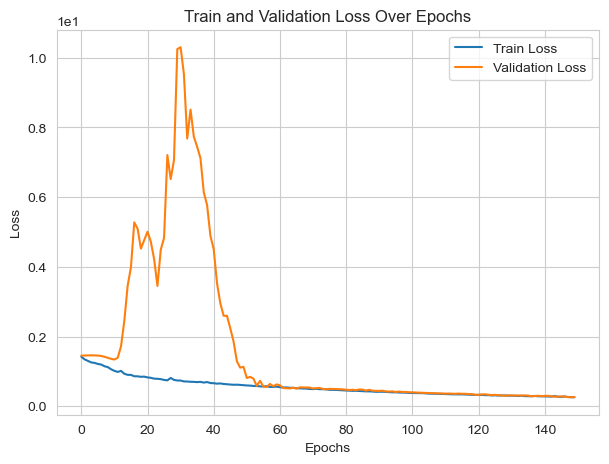

In [56]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train loss'], label='Train Loss')
plt.plot(data.index, data['valid loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


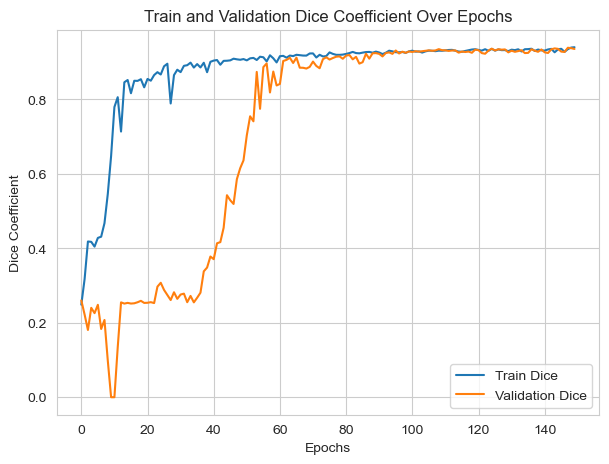

In [57]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train_dice'], label='Train Dice')
plt.plot(data.index, data['val_dice'], label='Validation Dice')

plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train and Validation Dice Coefficient Over Epochs')
plt.legend()
plt.show()


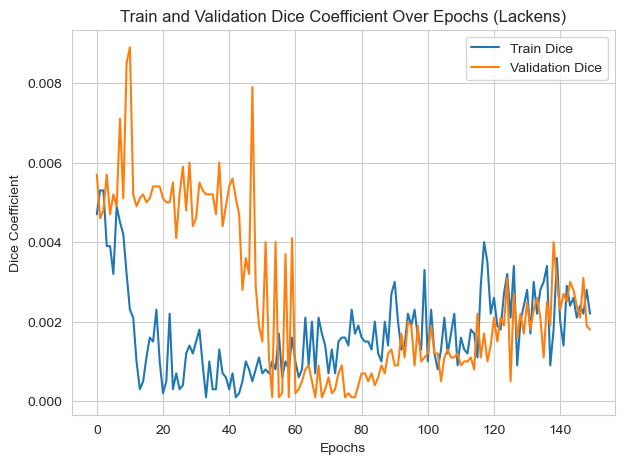

In [58]:
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['train_l_dice'], label='Train Dice')
plt.plot(data.index, data['val_l_dice'], label='Validation Dice')

plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train and Validation Dice Coefficient Over Epochs (Lackens)')
plt.legend()
plt.show()


#### Evaluating on Test Data

In [59]:
model = UNetFT(1)
state_dict = torch.load(model_file)  # Load the state_dict
model.load_state_dict(state_dict)  # Load weights into the model
model = model.to(device)
model.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_6240/2270770421.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/py

UNetFT(
  (encoder1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

Dice Coefficient: 0.8526024222373962
Dice Coefficient Lackens: 0.0043590255081653595
IoU: 0.735633134841919
IoU Lackens: 0.0019009599927812815
Accuracy: 0.9138784408569336
Accuracy Lackens: 0.49146613478660583


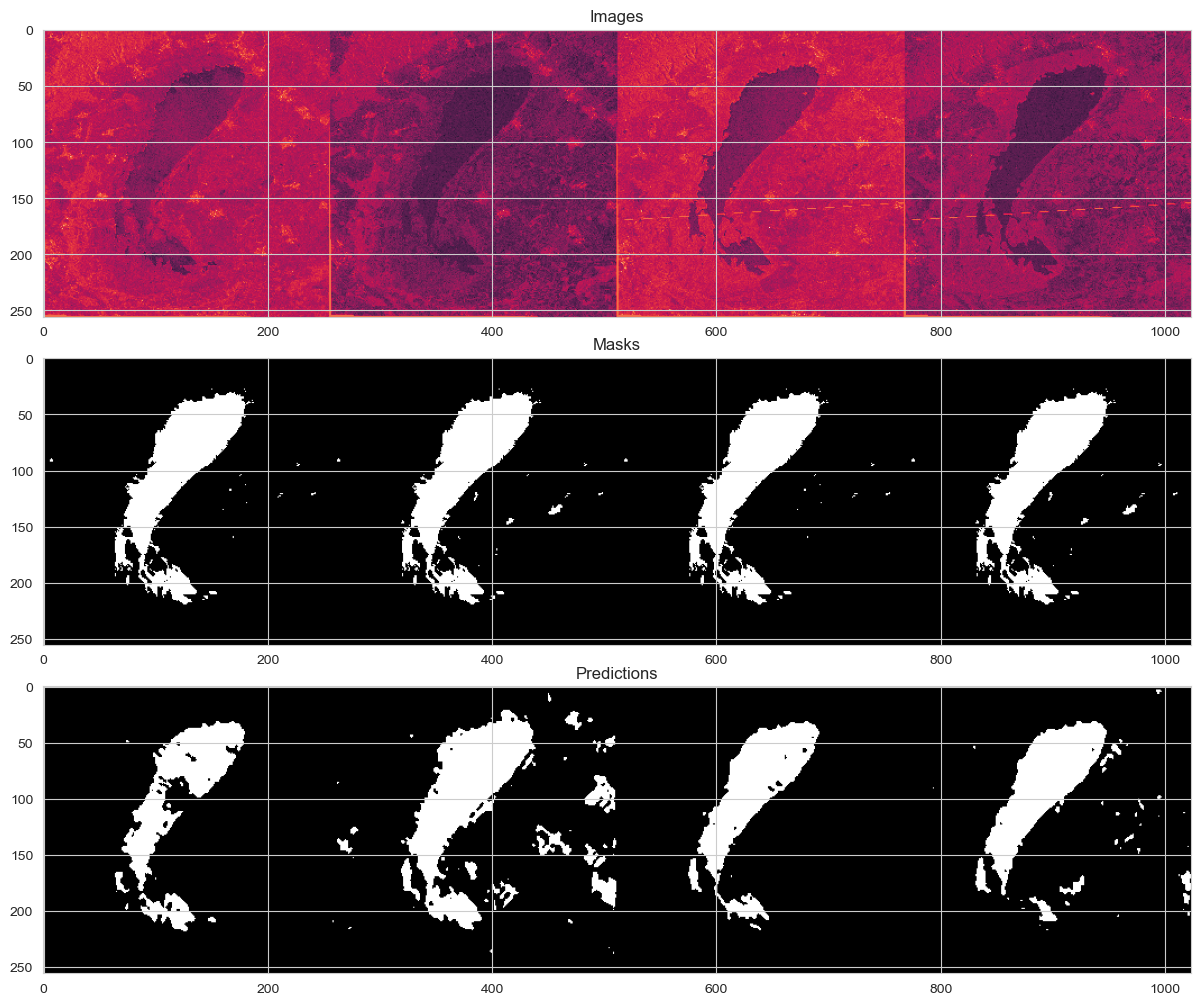

In [60]:

for images, masks, lacken_masks in testloader:
    with torch.no_grad():

        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()


    display_batch(images, masks, pred,lacken_masks)
